# Курс "Практикум по математической статистике"

# 3 курс ФПМИ МФТИ, осень 2025
## Практическое задание 1. Моделирование, оценки, свойства и сравнение.
### Дедлайн --- 27 сентября, 16:00

Это обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Сдавать ноутбук нужно будет в LMS.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.



In [41]:
from aptdaemon.worker.aptworker import read_high_trust_repository_dir
from wheel.macosx_libfile import swap32
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
%pip install --upgrade matplotlib numpy scipy statsmodels

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [42]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spo
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
%matplotlib inline

In [44]:
seed = np.random.seed(42)

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте".
Для моделирования оценки нужно:
- Сгенерировать много выборок (число можете подобрать сами, чтобы в итоге результат был репрезентативный, а ячейка считалась не дольше 5 минут)
- По каждой выборке посчитать оценку. **Указание:** считать надо не циклом, а векторными вычислениями. Вычисление циклом будет прощаться **только** если нет другого способа вычисления (исключительно редкий случай)
- Получить выборку оценок. По ней обычно бывает выгодно построить KDE, прикинуть распределение и возможно проверить его на QQ-plot, посчитать статистики распределения (дисперсию, например)

### Задача 1



В этой задаче мы будем моделировать поведение оценки медианой для распределения Лапласа с плотностью $\frac{1}{2}exp(-|x - \mu|)$.

В этой задаче Вам предстоит:
- Получить и визуализировать выборку оценок параметра $\mu$
- Построить эмпирическое приближение плотности оценки и изучить его свойства
- Проверить теоретические результаты численно и визуализировать их

1. Сделайте выборку из распределения Лапласа с параметром $\mu$ равном 9. На графике нарисуйте гистограмму выборки, плотность распределения и KDE.

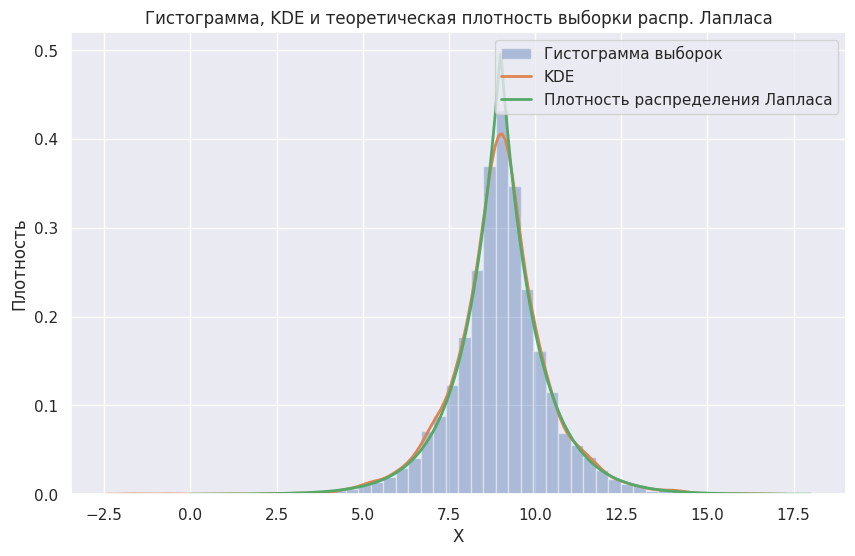

In [45]:
MU = 9
SCALE = 1
SAMPLE_SIZE = 5000

sample = sps.laplace(loc=MU, scale=SCALE).rvs(SAMPLE_SIZE, random_state=seed)

grid = np.linspace(0, MU*2, 1000)
pdf = sps.laplace(loc=MU, scale=SCALE).pdf(grid)

plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.hist(sample, bins=50, density=True, alpha=0.4, label="Гистограмма выборок")
sns.kdeplot(sample, lw=2, label="KDE")
plt.plot(grid, pdf, lw=2, label="Плотность распределения Лапласа")

plt.title("Гистограмма, KDE и теоретическая плотность выборки распр. Лапласа")
plt.xlabel("X"); plt.ylabel("Плотность"); plt.legend(loc="upper right")
plt.grid(True, which="both", linestyle="-", linewidth=1, alpha=1)
plt.show()

Похожи ли гистограмма, KDE и теоретическая плотность? Чем KDE как приближение лучше и хуже чем гистограмма?


<font color="#ae69c9ff">


Благодаря малому размеру бинов на гистограмме графики выглядят сильно похожими, что и ожидалось.\
KDE уступает гистограмме в приближении пика (хотя последняя и сама делает это плохо), но даёт более привычную/приятную глазу картинку.

2. Сделайте выбору выборок размера 10000 на 10000. Если Вычисление застрянет, можно уменьшить до 1000 на 1000. Постройте выборку оценок. Для упрощения визуализации, посчитайте $\sqrt{N}(\hat{\mu} - \mu)$, где $N$ это размер выборки, $\hat{\mu}$ это оценка, а $\mu$ --- параметр. Визуализируйте эту выборку гистограммой и KDE

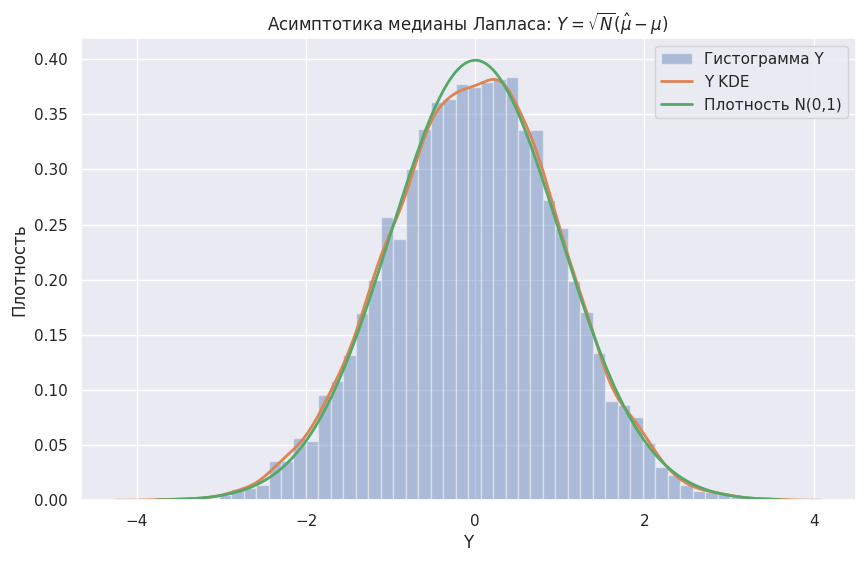

In [46]:
N = 10000

samples = sps.laplace(loc=MU, scale=SCALE).rvs(size=(N, N), random_state=seed)
mu_hat = np.median(samples, axis=1)
Y = N ** 0.5 * (mu_hat - MU)

grid = np.linspace(Y.min(), Y.max(), 600)
pdf = sps.norm().pdf(grid)

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.hist(Y, bins=50, density=True, alpha=0.4, label="Гистограмма Y")
sns.kdeplot(Y, lw=2, label="Y KDE")
plt.plot(grid, pdf, lw=2, label="Плотность N(0,1)")
plt.title(r"Асимптотика медианы Лапласа: $Y=\sqrt{N}(\hat{\mu}-\mu)$")
plt.xlabel("Y"); plt.ylabel("Плотность"); plt.legend(loc="upper right")
plt.grid(True, which="both", linestyle="-", linewidth=1, alpha=1)
plt.show()

Сделайте анализ и вывод полученного результата.

<font color="#ae69c9ff">

На графике видно распределение, которое очень похоже на нормальное. Величиной $Y=\sqrt{N}(\hat{\mu} - \mu)$ же является левой частью необходимого условия асимптотической нормальности оценки функции, а с семинаров по мат. статистике мы знаем, что оценка квантилем при опр. условиях ас. нормальна

3. Сделайте предположение о виде распределения величины $\sqrt{N}(\hat{\mu} - \mu)$ и проверьте его при помощи QQ-plot. Если сможете, объясните теоретически, почему Ваше распределение верно. Для каких случаев исходного распределения (вместо Лапласа) должно было получиться в результате такое же распределение (как у Вас)?

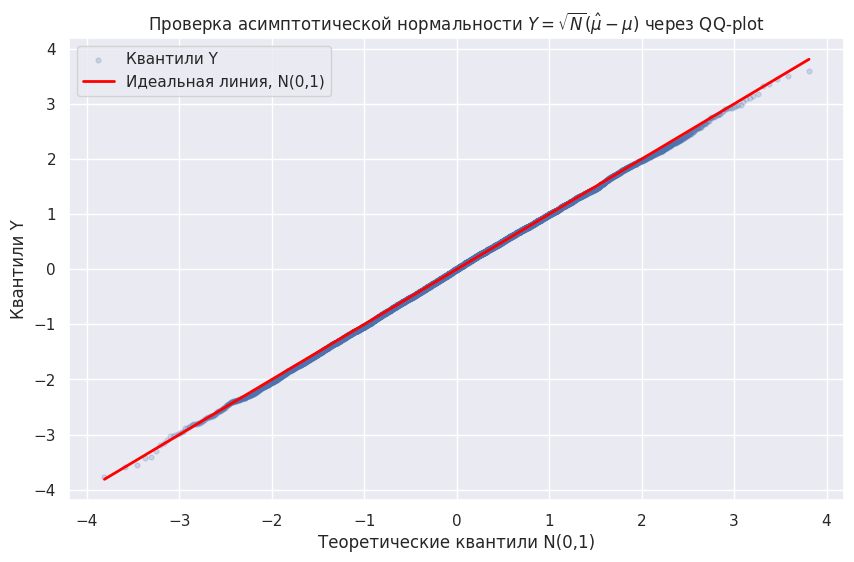

In [47]:
(osm, osr), _ = sps.probplot(Y, dist="norm")

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.scatter(osm, osr, s=12, alpha=0.2, label="Квантили Y")

lims = [min(osm.min(), osr.min()), max(osm.max(), osr.max())]
plt.plot(lims, lims, lw=2, label="Идеальная линия, N(0,1)", color = "red")

plt.xlabel("Теоретические квантили N(0,1)"); plt.ylabel("Квантили Y")
plt.title(r"Проверка асимптотической нормальности $Y=\sqrt{N}(\hat{\mu} - \mu)$ через QQ-plot")
plt.legend(); plt.grid(True, which="both", linestyle="-", linewidth=1, alpha=1)
plt.show()

<font color="#ae69c9ff">

Победа! Судя по qq-графику, очевидно, что полученное ранее распределение является нормальным. Аналогичный вывод можно сделать по теореме 3.3 (Об ас. нормальности выборочной квантили). Теорема даст стремление к $N(0,\frac{1}{4f^2(z_p)})$, в нашем случае $f(z_p)=1/2$, т.о. имеем $N(0,1)$ в пределе.


Какие выводы можно сделать, если точки в хвостах QQ-plot находятся выше/ниже своей прямой, как на картинке ниже? А если оба "хвоста" находятся с одной стороны прямой?


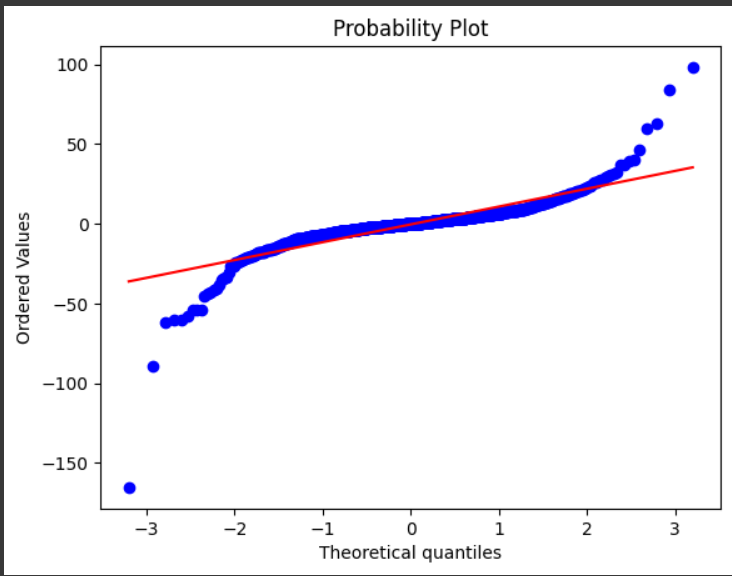

**Ответ:**

<font color="#ae69c9ff">

На графике: 
- распределение имеет более тяжёлые хвосты и, похоже, 2 горба в центре (на что намекает s-образная форма)
- оно близко к симметричному относительно OX
- иллюстрируемое распределение не смещено (или смещено слабо) и имеет высокую дисперсию  

Если 2 хвоста с одной стороны от прямой: 
- похоже, что мы имеем дело со скошенным нормальным распределением (пусть оба хвоста выше, тогда левый будет легче, а правый тяжелее)

4. Изучите, сходится ли оценка $\hat{\mu}$ к чему-то по вероятности с ростом N? Опишите, какой график Вы построите, чтобы это проверить и какие численные характеристики посчитаете для этого.

<font color="#ae69c9ff">

Хотим проверить оценку на состоятельность, для этого необходимо и достаточно (при наших прошлых предположениях) выполнения условия $\forall \varepsilon > 0 : P(|\hat{\mu} - \mu| > \varepsilon) \rightarrow 0$. Известно, что для теоретического распределения Лапласа медина (она же квантиль 1/2): $z_\frac{1}{2} = \inf\{x:F(x) \geq \frac{1}{2}\} = \beta$, где $p(x)=\frac{\alpha}{2}e^{-\alpha|x-\beta|}$.

Имеет смысл построить набор кривых $\hat{\mu_N} - \mu$, где шкала $OX$ будет логарифмической и отразит значение $N$. При этом мы должны увидеть, что подавляющее большинство кривых стремятся к 0, а выбросов нет/крайне мало в пределах погрешности, т.о. После нужно будет добавить границы интервала для малого $\varepsilon$, и общий график будет идентичен примеру с сост. и несост. оценками с первого семинара.

На практике статисты не отличают состоятельность от сильной состоятельности (сходимость по вероятности и почти наверное) и проверяют оба свойства одинаково. Годится ли наш метод практической проверки для проверки сильной состоятельности? Как можно было бы проверить её качественнее?

**Ответ**:

<font color="#ae69c9ff">

Нам метод для проверки сильной состоятельности не годится, но по предложенному построению графика можно будет сделать хотя бы слабый эмпирический вывод, что сильная состоятельности может быть, в случае отсутствия на графике выбросов. Кроме того, на график можно нанести супремумы $|\hat{\mu} - \mu|$ на отрезках $[N_i, N_{i+1}]$, что явно покажет отсутствие/наличие выбросов при высокой прозрачности линий.

5. Посчитайте среднее и выборочную дисперсию оценки для разных N. Как они ведут себя в пределе?

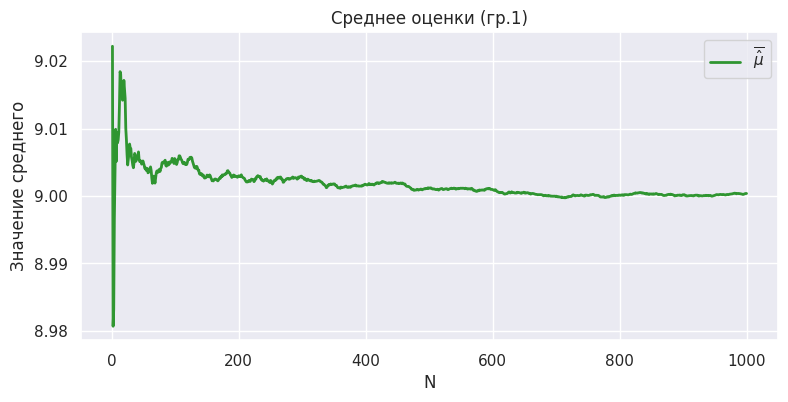

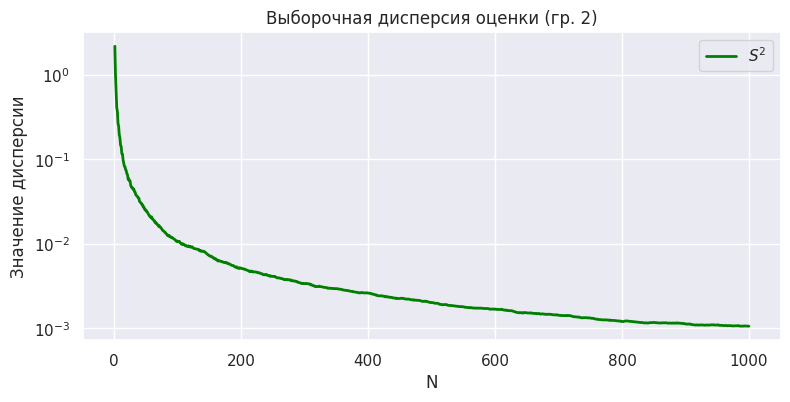

In [48]:
N = 1000
samples = sps.laplace(loc=MU, scale=SCALE).rvs(size=(N, N), random_state=seed)

n_range = np.arange(1, N+1)
aver = np.empty(N)
var = np.empty(N)

for i in n_range:
    mu_i_hat = np.median(samples[:, :i], axis=1)
    var[i - 1] = mu_i_hat.var(ddof=1)
aver = np.cumsum(mu_i_hat)/n_range

plt.figure(figsize=(9,4))
plt.plot(n_range, aver, lw=2, color="green", alpha=0.8, label=r"$\overline{\hat{\mu}}$")
plt.title("Среднее оценки (гр.1)")
plt.xlabel("N"); plt.ylabel("Значение среднего"); plt.legend(); plt.grid(True)

plt.figure(figsize=(9,4))
plt.plot(n_range, var, lw=2, color="green", label="$S^2$")
plt.title("Выборочная дисперсия оценки (гр. 2)")
plt.xlabel("N"); plt.yscale("log"); plt.ylabel("Значение дисперсии"); plt.legend(); plt.grid(True)
plt.show()

<font color="#ae69c9ff">

Гр. 1: На малых N наблюдается большая осцилляция, нежели на больших, однако явно выражен тренд быстрой сходимости к теоретической оценке, к $\mu$. Это происходит по сильной состоятельности оценки.\
Гр. 2: Явно виден тренд сходимости вида $\frac{1}{n}$, полагаю, это связано с тем, что ... я не знаю.

<span style="color:red">
Ну как же так, Иван...
У вас асимптотическая дисперсия почти что равна дисперсии $\sqrt{N}(\hat{\mu} - \mu)$, а она равна N на дисперсию медианы. Получается, она пропорциональная асимп. дисперсии, делённой на N.

</span>

6. Постройте KDE величины $\sqrt{N}(\hat{\mu} - \mu)$ для разных $N$. Можно ли говорить о равномерной сходимости их к какой-то функции? Что это за функция?

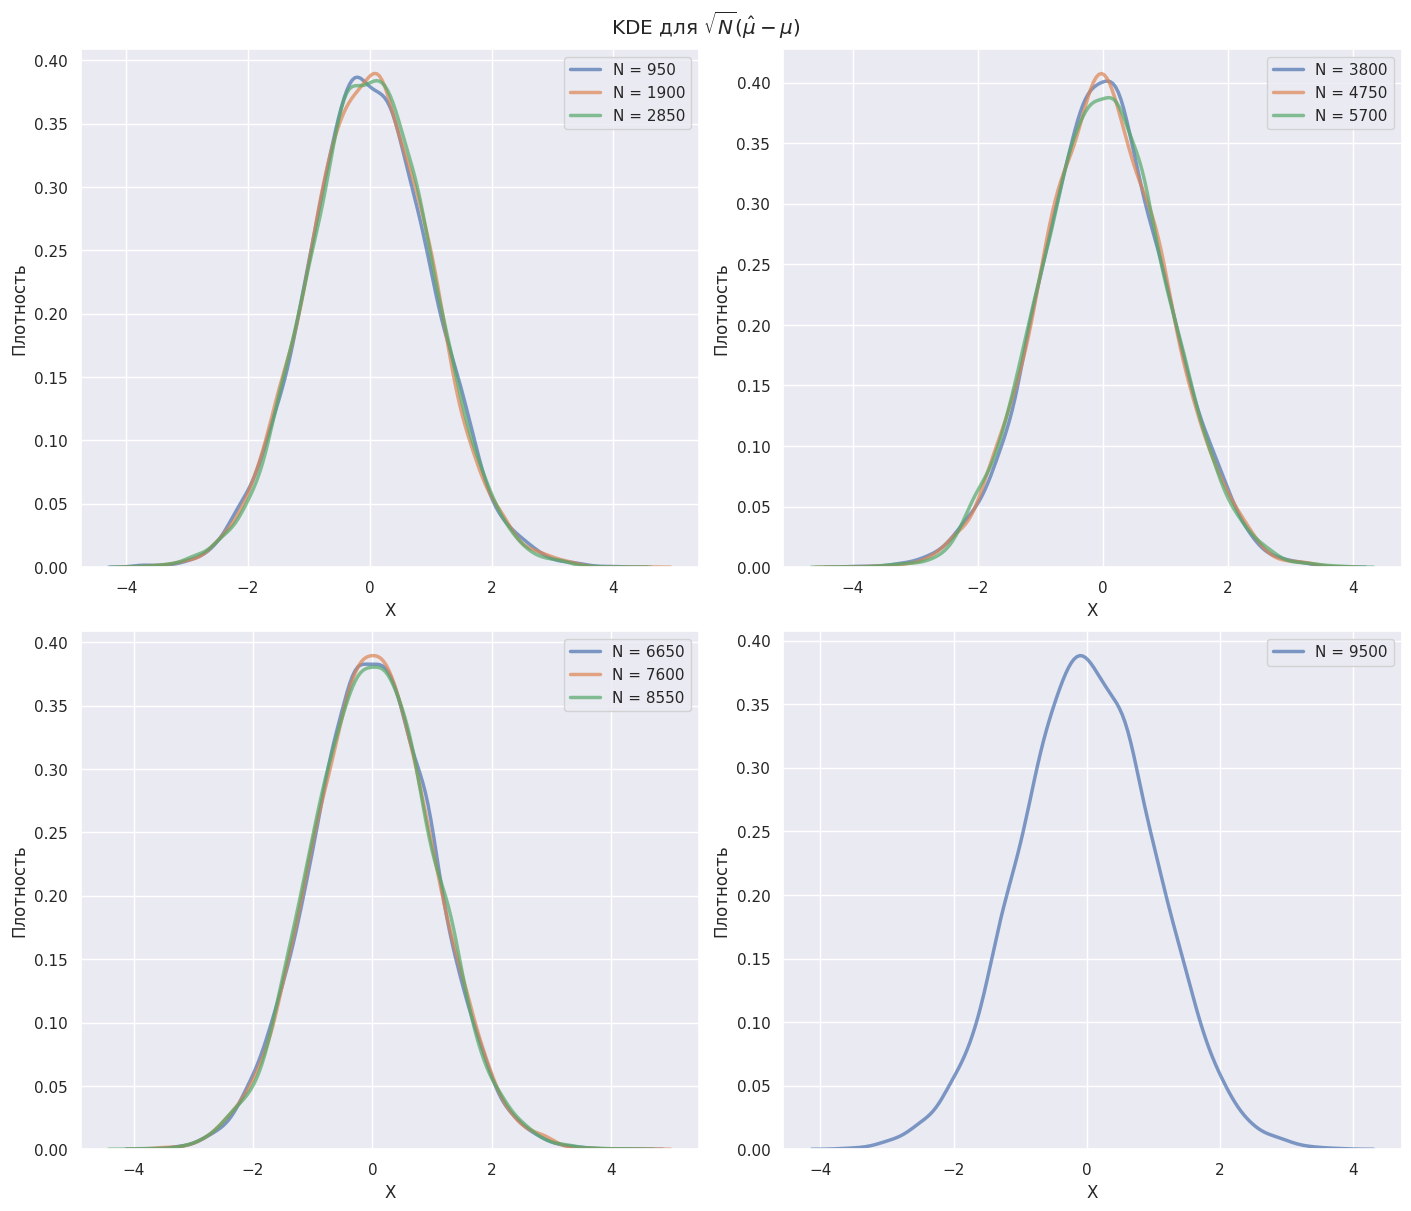

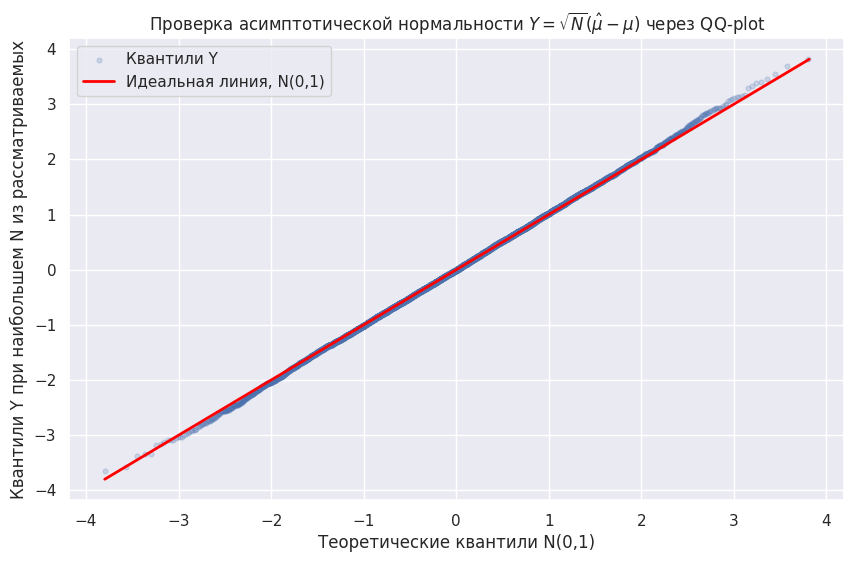

In [49]:
N = 9500
samples = sps.laplace(loc=MU, scale=SCALE).rvs(size=(N, N), random_state=seed)

n_range = np.arange(1, N+1)

ns = []
for i in range(4):
    for j in (n_range * N / 10)[i * 3 : (i + 1) * 3]:
        ns.append(int(j))
        
ns = ns[:-2]

Y = np.zeros((N, N))

for i in ns:
    mu_i_hat = np.median(samples[:, :i], axis=1)
    Y[:, i-1] = i ** 0.5 * (mu_i_hat - MU)
    
    
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=False, sharey=False, constrained_layout=True)
sns.set(style="darkgrid")

for i in range(4):
    pos = axes.ravel()[i]
    for j in (n_range * N / 10)[i * 3 : (i + 1) * 3]:
        sns.kdeplot(x=Y[:, int(j)-1], lw=2.5, ax=pos, bw_adjust=1, label="N = " + str(int(j)), alpha=0.7)
        pos.legend(loc="upper right"); pos.set_xlabel("X"); pos.set_ylabel("Плотность")
        if i == 3: break

fig.suptitle(r"KDE для $\sqrt{N}(\hat{\mu}-\mu)$")
plt.show()


(osm, osr), _ = sps.probplot(Y[:, N-1], dist="norm")

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.scatter(osm, osr, s=12, alpha=0.2, label="Квантили Y")

lims = [min(osm.min(), osr.min()), max(osm.max(), osr.max())]
plt.plot(lims, lims, lw=2, label="Идеальная линия, N(0,1)", color = "red")

plt.xlabel("Теоретические квантили N(0,1)"); plt.ylabel("Квантили Y при наибольшем N из рассматриваемых")
plt.title(r"Проверка асимптотической нормальности $Y=\sqrt{N}(\hat{\mu} - \mu)$ через QQ-plot")
plt.legend(); plt.grid(True, which="both", linestyle="-", linewidth=1, alpha=1)
plt.show()

<font color="#ae69c9ff">

По графикам видна сходимость по распределению к $N(0,1)$ (особенно хорошо это иллюстрирует qq-график), но большего по типу равномерной сходимости только на основе графиков утверждать нельзя

### Задача 2



В этой задаче мы будем работать с известной оценкой высокого качества --- Оценкой Максимального Правдоподобия (ОМП).

В этой задаче Вам предстоит:
- Записать правдоподобие как функцию для оптимизации
- Численно при помощи градиентного спуска найти оценку
- Изучить её предельное поведение

**В данной задаче разрешается не писать метод Ньютона и градиентный спуск руками, а пользоваться scipy.optimize**.

<font color="#ae69c9ff">

Правдоподобие выборки из непрерывного распределения это произведение плотностей её элементов (правдоподобие данной выборки --- функция, зависящая только от параметров распределения). Оценка максимального правдоподобия --- такое значение параметра, при котором правдоподобие максимально.

1. Выпишите функцию правдоподобия выборки из $N$ элементов. Какому уравнению удовлетворяет оценка (как максимум этой функции)? Глядя на получившуюся формулу объясните, в чём основной недостаток оценки ОМП, если выборка состоит из большого числа элементов?

<font color="#ae69c9ff">

Функция правдоподобия выборки $(X_1,\dots,X_n)$: $f_\theta(X_1,\dots,X_n) = p_\theta(X_1) \dots p_\theta(X_n).$\
Оценкой функции максимального правдоподобия параметра $\theta$ называется $\hat{\theta}(X_1, \dots, X_n) = \arg\max_{\theta\in\Theta}f(X_1, \dots, X_n)$. Для $f \in C_1$ необходимое условие: $\theta$ является решением уравнения $\nabla_\theta f_N(\hat\theta) = \nabla_\theta \prod_{i=1}^N p_\theta(x_i) = \overline 0$.

Явно бросается в глаза 2 недостатка ОМП:
1. В случае дискретного распределения, если значение плотности будет 0, то вся функция занулится
2. Даже если все плотности примут не нулевые значения, ОМП будет стремиться к нулю с экспоненциальной скоростью и мы быстро упрёмся в предел точности вычислений

2. Сгенерируйте выборку из распределения Коши с параметром сдвига 9 из 100 элементов.

Градиентный спуск это алгоритм поиска минимума функции, который "шагает" по минус градиенту (антиградиенту), пока тот не обнулится. Этот алгоритм имеет смысл, так как градиент указывает в сторону возрастания функции.

Попробуйте выписать производную функции правдоподобия для выборки из 100 элементов. Если у Вас это получилось, подайте эту производную в функцию scipy.optimize.minimize и посмотрите, какой результат эта функция Вам предложит.

In [50]:
X0 = 9
SCALE = 1
SAMPLE_SIZE = 100

sample = sps.cauchy(loc=X0, scale=SCALE).rvs(SAMPLE_SIZE, random_state=seed)

def p(theta, x):
    t = np.asarray(theta).item()
    return 1 / (np.pi * (1 + (x - t) ** 2))

def dp(theta, x):
    t = np.asarray(theta).item()
    return 2 * (x - t) / (np.pi * (1 + (x - t) ** 2) ** 2)

def f(theta, X):
    t = np.asarray(theta).item()
    return - np.prod([p(t, x) for x in X]), dL(theta, X)

def dL(theta, X):
    t = np.asarray(theta).item()
    ans = np.zeros(SAMPLE_SIZE)
    for i in range(SAMPLE_SIZE):
        ans[i] = dp(t, X[i]) / p(t, X[i])
    return - sum(ans) * np.prod([p(t, x) for x in X])

print(spo.minimize(fun=f, jac=True, args=(sample,), x0=7))


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -4.226892805149129e-139
        x: [ 7.000e+00]
      nit: 0
      jac: [-2.003e-137]
 hess_inv: [[1]]
     nfev: 1
     njev: 1


Если у Вас всё почему-то сломалось, объясните почему.

<font color="#ae69c9ff">

Ну да, действительно всё сломалось. Вне зависимости от предложенной точки x0 метод работает некорректно из-за чрезмерно высокой скорости сходимости f к 0. Некорректность выражается в том, что метод завершает работу за одну итерацию.

 3. Вместо максимизации правоподобия статисты минимизируют минус логарифм правдоподобия (называя его логправдоподобием). Объясните, чем это лучше.

Посчитайте производную минус логарифма правдоподобия и подайте её снова в scipy.optimize.minimize. Предложите хорошую стартовую точку для метода? Как Вам кажется, какая оценка параметра сдвига может быть хорошим стартом для поиска ОМП?

In [51]:
def p(theta, x):
    t = np.asarray(theta).item()
    return 1 / (np.pi * (1 + (x - t) ** 2))

def dp(theta, x):
    t = np.asarray(theta).item()
    return 2 * (x - theta) / (np.pi * (1 + (x - t) ** 2) ** 2)

def f(theta, X):
    t = np.asarray(theta).item()
    return - sum([np.log(p(t, x)) for x in X]), dl(t, X)

def dl(theta, X):
    t = np.asarray(theta).item()
    ans = np.zeros(X.size)
    for i in range(X.size):
        ans[i] = dp(t, X[i]) / p(t, X[i])
    return - sum(ans)

print(spo.minimize(fun=f, jac=True, args=(sample,), x0=100))
print(np.median(sample))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 257.4102577138393
        x: [ 8.906e+00]
      nit: 4
      jac: [ 9.018e-08]
 hess_inv: [[ 2.226e-02]]
     nfev: 16
     njev: 16
8.829569471955796


<font color="#ae69c9ff">

~Как будто бы здесь в самом задании лажа/я его не понимаю. Я нахожу странным минимизировать производную минус логарифма правдоподобия, когда мы хотим узнать минимум функции. Я подал на вход оптимизатору функцию, равную минус логарифм функции МП, и он вернул оценку, которая на беглый взгляд кажется разумной.~ Ну и тз.. Сделал, как сказали в чате.\
Если поверить в теорему 3.3 из методички (вроде б/д в курсе), то медиана является ас. нормальной оценкой для распределения Коши -> разумно предположить, что применив ОПМ мы получим её же.\
В коде я взял x0, как 100 в качетсве доп. проверки, что ничег не сломается. Оптимально взять медиану или же $X0$ (aka смещение распределения Коши) непосредственно. Я утверждаю, что т.к. распр. Коши симметрично отн. $X0$, то и медиана будет лежать близко к нему.

<span style="color:red">Потому что минимум логарифма функции то же самое, что и минимум исходной функции. Было бы неплохо это и написать (-1)</span>

У4. Найдите ОМП для размеров выборки от 10 до 1000 с какой-то сеткой. Изобразите их на графике. Сходятся ли они к чему-то?

In [52]:
SAMPLE_SIZE = 1000

sample = sps.cauchy(loc=X0, scale=SCALE).rvs(SAMPLE_SIZE, random_state=seed)

seq = np.zeros(SAMPLE_SIZE - 10)
for i in range(seq.size):
    seq[i] = spo.minimize(fun=f, jac=True, args=(sample[:i + 10],), x0=9).x.item()

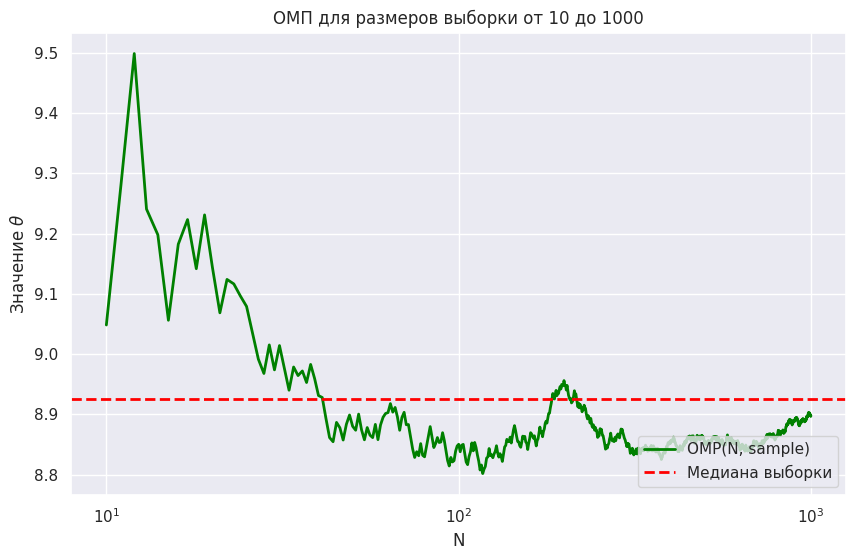

In [53]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
plt.plot(np.arange(10, SAMPLE_SIZE), seq, lw=2, color="green", label="OMP(N, sample)")
plt.axhline(np.median(sample), lw=2, color="red", ls="--", label="Медиана выборки")
plt.title("ОМП для размеров выборки от 10 до 1000")
plt.xlabel("N"); plt.xscale("log"); plt.ylabel(r"Значение $\theta$"); plt.legend(loc="lower right"); plt.grid(True)
plt.show()

<font color="#ae69c9ff">

На графике явно видна сходимость оценки к $X0$. Хочется утверджать, что оценка состоятельная, т.к. она близка к медиане, а последняя таковой является.

5. Для $N = 1000$ изобразите KDE и/или QQ-plot величины $\sqrt{N}(\hat{\theta} - \theta)$ и выясните, к какому предельному распределению оно сходится.

<Figure size 1000x600 with 0 Axes>

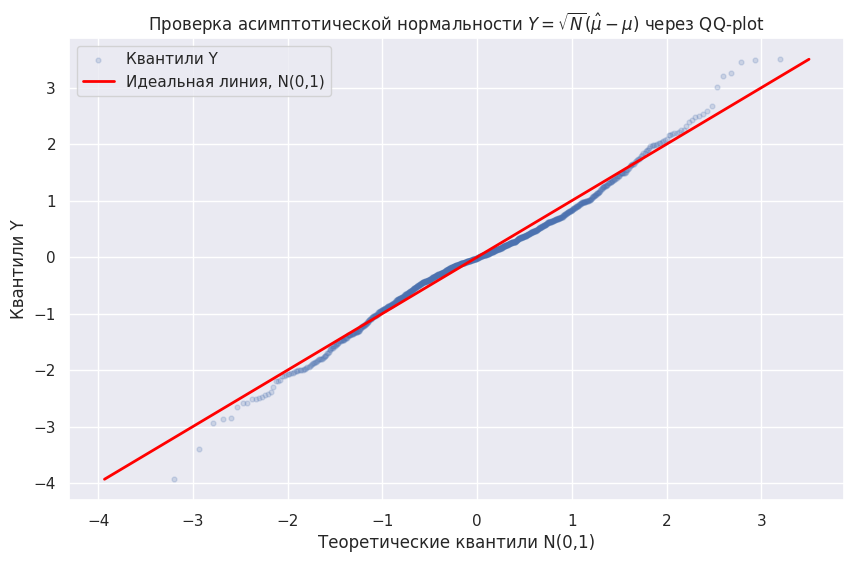

In [54]:
samples = sps.cauchy(loc=X0, scale=SCALE).rvs((SAMPLE_SIZE, SAMPLE_SIZE), random_state=seed)


sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

Y = np.arange(1, SAMPLE_SIZE + 1) ** 0.5 * [(spo.minimize(fun=f, jac=True, args=(samples[i, :],), x0=9).x.item() - X0) for i in range(SAMPLE_SIZE)]

plt.figure(figsize=(10, 6))
(osm, osr), _ = sps.probplot(Y, dist="norm")
plt.scatter(osm, osr, s=12, alpha=0.2, label="Квантили Y")

lims = [min(osm.min(), osr.min()), max(osm.max(), osr.max())]
plt.plot(lims, lims, lw=2, label="Идеальная линия, N(0,1)", color = "red")

plt.xlabel("Теоретические квантили N(0,1)"); plt.ylabel("Квантили Y")
sns.kdeplot(x=Y, lw=2.5, ax=pos, bw_adjust=1, label="N = " + str(int(j)), alpha=0.7)
plt.title(r"Проверка асимптотической нормальности $Y=\sqrt{N}(\hat{\mu} - \mu)$ через QQ-plot")
plt.legend(); plt.grid(True, which="both", linestyle="-", linewidth=1, alpha=1)
plt.show()

<span style="color:red">Ты тут зачем-то считаешь величину не для одного и того же значения N, которое указано в условии, а для всех от 1 до SAMPLE_SIZE. Логично, что для малых размеров выборки получится фигня, так как для них нормальное приближение ещё не очень хорошее (-1)</span>

<font color="#ae69c9ff">

Большинство точек лежат на прямой, благодаря чему можно сделать вывод о том, что распределение близко к нормальному (хотя если перегенерировать данные несколько раз, то в ряде случаев получаются малые горбы),а в пределе таковым должно быть. Ура-ура, теорема 3.3 опять пытается работать.\
В отклонении "хвостов" распределения от оси я хочу обвинить конечную выборку и малое N. Теорема всё-таки предельная, а про скорость сходимости мы пока ничего не знаем.

### Задача 3

В этой задаче мы изучим способы сравнения оценок между собой.

Мы будем оценивать параметр $\theta$ распределения $U[0, \theta]$ следующими способами: $2\overline{X}$, $\frac{n+1}{n} X_{(n)}$, $(n+1)X_{(1)}$, $\overline{X} + X_{(n)}/ 2$ и $X_{(1)}+X_{(n)}$. Зафиксируем конкретное значение параметра $\theta = 9$.

В этой задаче Вам предстоит:
- Промоделировать и сравнить все предложенные оценки
- Посчитать численный риск и убедиться, что это разумная метрика качества оценки
- Применить равномерный и байесовский подходы к сравнению оценок

1. Промоделируйте каждую из оценок. Постройте все оценки на графике в единых осях или на таблице графиков с общими осями. Если будут расхождения в масштабах, ниже постройте отдельные графики для оценок с разными подходящими масштабами.

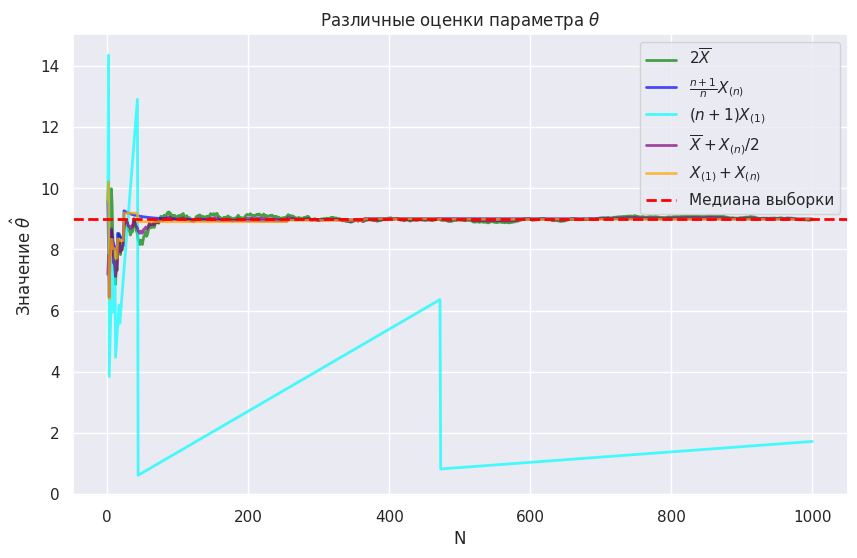

In [55]:
SAMPLE_SIZE = 1000
THETA = 9

sample = sps.uniform(0, THETA).rvs(SAMPLE_SIZE, random_state=seed)

n_range = np.arange(1, SAMPLE_SIZE + 1)
Xa = 2 * np.cumsum(sample) / n_range
Xb = (n_range + 1) / n_range * np.maximum.accumulate(sample)
Xc = (n_range + 1) * np.minimum.accumulate(sample)
Xd = Xa / 2 + np.maximum.accumulate(sample) / 2
Xe = np.minimum.accumulate(sample) + np.maximum.accumulate(sample)

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(n_range, Xa, lw=2, alpha=0.7, color="green", label=r"$2\overline{X}$")
plt.plot(n_range, Xb, lw=2, alpha=0.7, color="blue", label=r"$\frac{n+1}{n} X_{(n)}$")
plt.plot(n_range, Xc, lw=2, alpha=0.7, color="cyan", label=r"$(n+1)X_{(1)}$")
plt.plot(n_range, Xd, lw=2, alpha=0.7, color="purple", label=r"$\overline{X} + X_{(n)}/2$")
plt.plot(n_range, Xe, lw=2, alpha=0.7, color="orange", label=r"$X_{(1)}+X_{(n)}$")
plt.axhline(THETA, lw=2, color="red", ls="--", label="Медиана выборки")

plt.title(r"Различные оценки параметра $\theta$")
plt.xlabel("N"); plt.ylabel(r"Значение $\hat{\theta}$"); plt.legend(loc="best"); plt.grid(True)
plt.show()

<span style="color:red">В этом пункте нужно было промоделировать оценки, то есть посмотреть на распределение оценок. Размер выборки тут менять не нужно было. (-1)</span>

<font color="#ae69c9ff">

Все оценки, кроме третьей быстро сходятся к 0, график отлично иллюстрирует дз ко второму семинару по мат. статам, выполнив которое, мы научились проверять оцени на асимптотическую устойчивость, несмещённость и состоятельность. Все предложенные оцени были описаны в дз и разобраны на семинаре.

G"2. Изучите, как меняются распределения оценок с изменением размера выборки. Для этого постройте KDE для 4-5 разных размеров на одном графике. Для каждой оценки сделайте отдельный такой график. Сделайте выводы о предельном поведении оценок.

In [56]:
SAMPLE_SIZE = 10000

samples = sps.uniform(0, THETA).rvs((SAMPLE_SIZE, SAMPLE_SIZE), random_state=seed)

n_range = np.arange(1, SAMPLE_SIZE+1)

ns = np.arange(1, 6) * int(SAMPLE_SIZE / 5)

n_range = np.arange(1, SAMPLE_SIZE + 1)
Xa = 2 * np.cumsum(samples, axis=1) / n_range
Xb = (n_range + 1) / n_range * np.maximum.accumulate(samples, axis=1)
Xc = (n_range + 1) * np.minimum.accumulate(samples, axis=1)
Xd = Xa / 2 + np.maximum.accumulate(samples, axis=1) / 2
Xe = np.minimum.accumulate(samples, axis=1) + np.maximum.accumulate(samples, axis=1)
distr = [Xa, Xb, Xc, Xd, Xe]

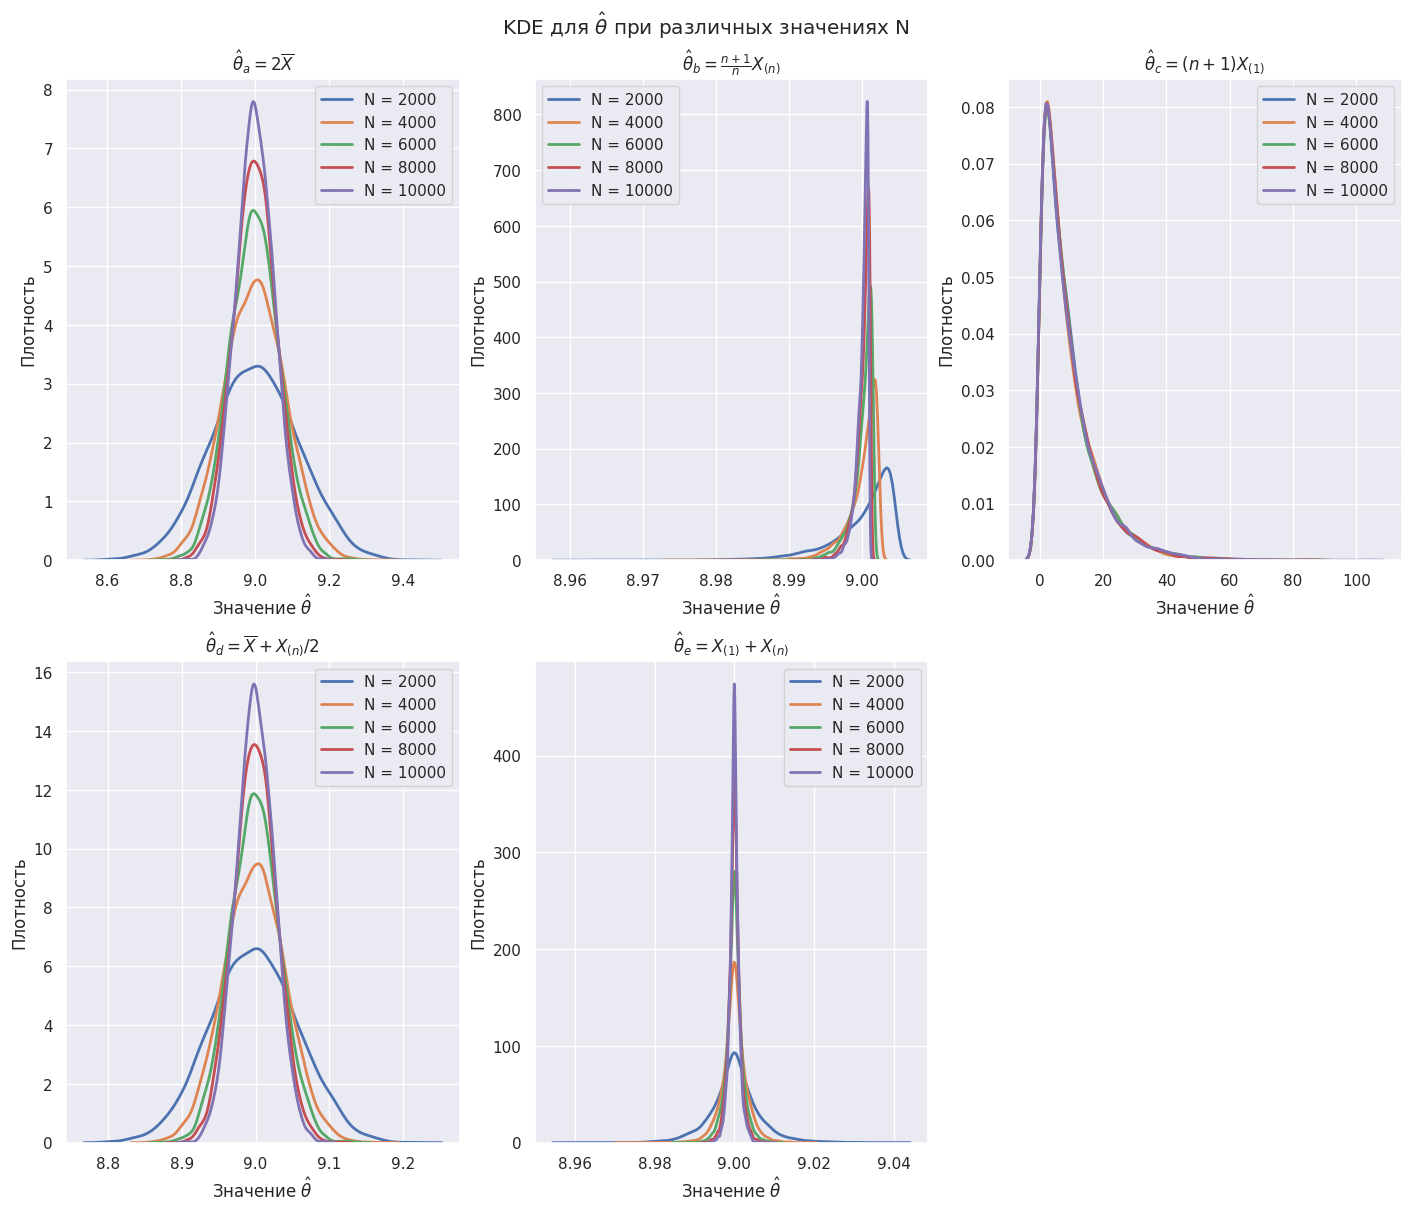

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(14, 12), sharex=False, sharey=False, constrained_layout=True)
sns.set(style="darkgrid")

titles = [r"$\hat\theta_a = 2\overline{X}$", r"$\hat\theta_b = \frac{n+1}{n} X_{(n)}$",
          r"$\hat\theta_c = (n+1)X_{(1)}$", r"$\hat\theta_d = \overline{X} + X_{(n)}/2$",
          r"$\hat\theta_e = X_{(1)}+X_{(n)}$"]

for i in range(len(distr)):
    pos = axes.ravel()[i]
    for j in range(5):
        sns.kdeplot(x=(distr[i][:, ns[j] - 1]), lw=2, alpha=1, ax=pos, label="N = " + str(ns[j]))
    pos.legend(loc="best"); pos.set_xlabel(r"Значение $\hat{\theta}$"); pos.set_ylabel("Плотность")
    pos.set_title(titles[i])


fig.suptitle(r"KDE для $\hat{\theta}$ при различных значениях N")
fig.delaxes(axes.ravel()[5])
plt.show()

<font color="#ae69c9ff">

1. Оценка неплохая, распределение похоже на нормальное. Учитывает большое количество данных, что хорошо
2. Просто супер вкусняшка, со стремлением N к бесконечности будет топ 1-2 по эффективности приближения. Имеет лёгкий скос слева, но вроде как это не плохо. Распределение похоже на экспоненциальное
3. Очень широкий скос справа, при увеличении N оценка практически не изменяется -> я не наблюдаю признаков сходимости по вероятности к $\hat{\theta}$.
4. Оценка хорошая, учитывает как среднее, так и максимум, из-за чего даёт чуть более высокий пик, чем первая.
5. Пушка-конфетка, при увеличении N края распределения всё сильнее прижимаются к горизонтальной оси, а пик растёт

3. Сделайте промежуточный вывод по графикам какая оценка самая лучшая и обоснуйте его. Используйте для этого все полученные результаты.

<font color="#ae69c9ff">

Наиболее интересными выглядят распределения 2 и 5. Первый график даёт мало информации про эти распределения, третий не сходится к $\theta$, четвёртая оценка имеет широкое основание, а вот на втором и пятом графиках явно видны наиболее узкие основания и острые пики; кроме того, обе оценки выглядят несмещёнными. Это хорошо, так как ширина пика примерно показывает дисперсию, а чем она меньше, тем лучше.\
Судя по графикам, в теоретическом случае оценка $\hat\theta_b = \frac{n+1}{n} X_{(n)}$ имеет более острый пик (плотность на нём принимает большие значения), поэтому на данный момент я нахожу эту оценку лучшей (с семинаров по мат. статам я знаю, что оценки 2 и 5 несмещённые).

4. Для каждой оценки для квадратичной функции потерь найдите эмпирический риск. Для первых трёх оценок посчитайте точный риск. Интеграл можно брать руками, вольфрамом или функцией scipy.integrate.quad. Сделайте выводы о том, хорошо ли эмпирический риск приближает точный риск. После этого сравните оценки на основании эмпирического риска. Совпадает ли порядок с тем, что Вы сделали глядя на графики? Почему?

<font color="#ae69c9ff">

Явно выпишем найденные в домашней работе и разобранные на семинаре + в конспекте Андрея Куссева (легенда, спасибо за детство) функции риска для первых трёх оценок:
1. $\hat\theta_a = 2\overline{X}: R(\hat\theta_a, \theta) = \frac{\theta^2}{3n}.$
2. $\hat\theta_b = \frac{n+1}{n} X_{(n)}: R(\hat\theta_b, \theta) = \frac{\theta^2}{n(n+2)}.$
3. $\hat\theta_c = (n+1)X_{(1)}: R(\hat\theta_c, \theta) = \frac{n}{n+2}\theta^2.$

<span style="color:red">🥰</span>

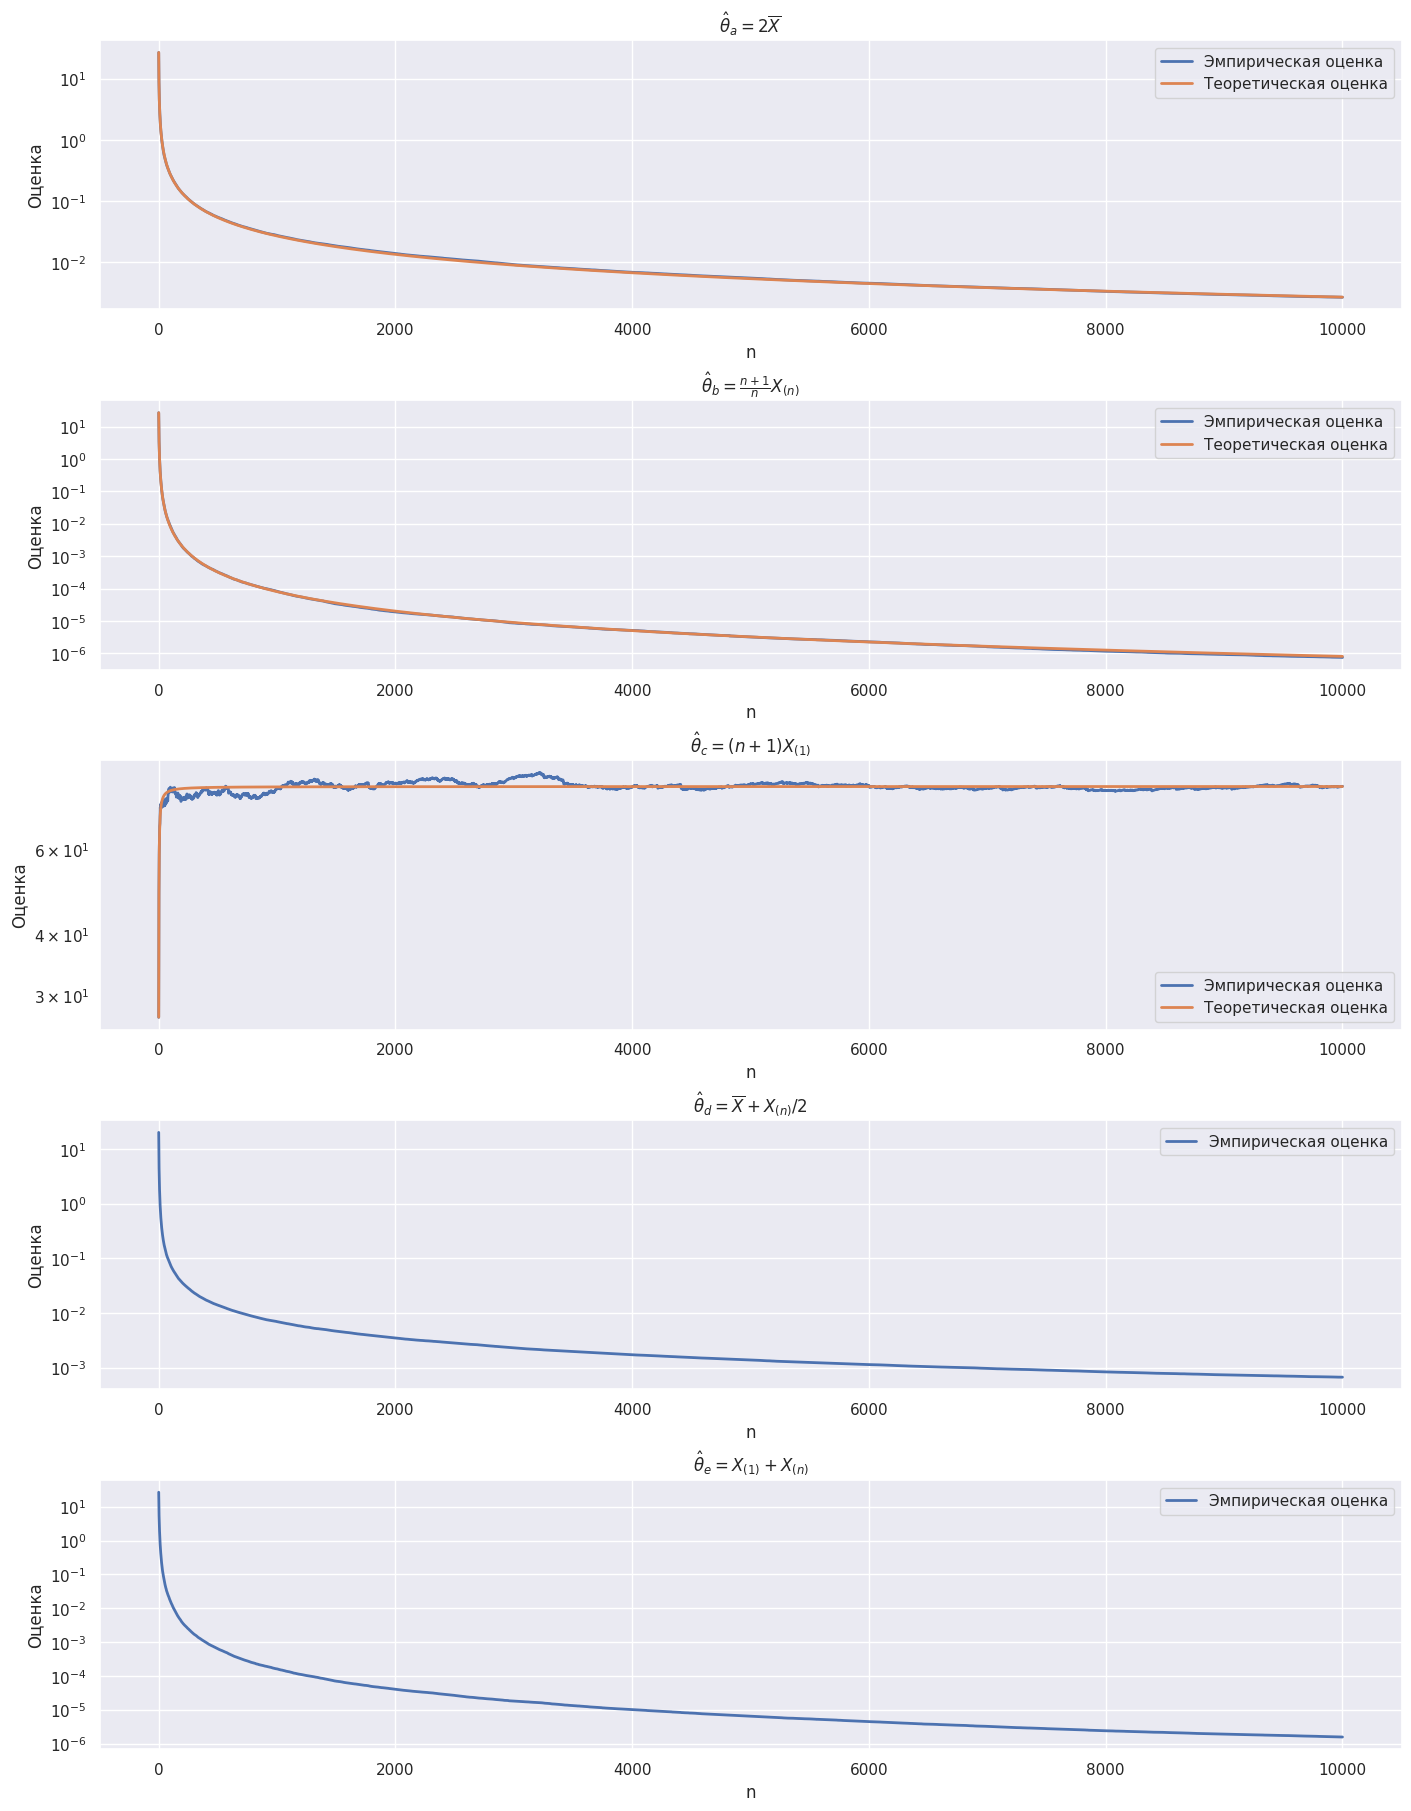

In [58]:
def R_emp(X, th = THETA):
    return ((X - th) ** 2).mean(axis=0)

R_Xa_th = THETA ** 2 / (3 * n_range)
R_Xb_th = THETA ** 2 / (n_range * (n_range + 2))
R_Xc_th = THETA ** 2 * n_range / (n_range + 2)

emp = [R_emp(X) for X in distr]
theor = [R_Xa_th, R_Xb_th, R_Xc_th]

fig, axes = plt.subplots(len(emp), 1, figsize=(14, 18), sharex=False, sharey=False, constrained_layout=True)
sns.set(style="darkgrid")
titles = [r"$\hat\theta_a = 2\overline{X}$", r"$\hat\theta_b = \frac{n+1}{n} X_{(n)}$", r"$\hat\theta_c = (n+1)X_{(1)}$", r"$\hat\theta_d = \overline{X} + X_{(n)}/2$", r"$\hat\theta_e = X_{(1)}+X_{(n)}$"]

for i in range(len(emp)):
    pos = axes.ravel()[i]
    pos.plot(n_range, emp[i], lw=2, alpha=1, label="Эмпирическая оценка")
    if i < len(theor):
        pos.plot(n_range, theor[i], lw=2, alpha=1, label="Теоретическая оценка")
    pos.legend(loc="best"); pos.set_xlabel(r"n"); pos.set_ylabel("Оценка"); pos.set_yscale("log")
    pos.set_title(titles[i])
plt.show()

<font color="#ae69c9ff">

_здесь n - то же, что и N на предыдущих графиках: размер выборки_

<font color="#ae69c9ff">

Для первых двух оценок эмпирический риск замечательно приблизил теоретический, связываю это с достаточно большой выборкой, наличием сходимости по вероятности и, самое главное, высокой скоростью убывания функции. На третьей оценке дисперсия осциллирует. На мой взгляд, причина тряски связана с отсутствием сходимости и низкой скоростью убывания. Про скорость убывания и гладкость 4 и 5 - аналогично 1 и 2.\
Полученные порядки убывания совпадают с теми, что видели на графиках, ибо ~такова бренность бытия~ мы смотрим на одни и те же объекты с разных сторон.\
Итог: Функции потерь от лучшей к худшей:
1. $\hat\theta_b = \frac{n+1}{n} X_{(n)}$
2. $\hat\theta_e = X_{(1)}+X_{(n)}$
3. $\hat\theta_d = \overline{X} + X_{(n)}/2$
4. $\hat\theta_a = 2\overline{X}$
5. $\hat\theta_c = (n+1)X_{(1)}$

Какой характеристикой распределения является квадратичный риск? Какому свойству графика плотности оценки она соответствует?

<font color="#ae69c9ff">

Как я уже неявно упомянуло ранее, квадратичный риск для несмещённых распределений равен дисперсии, а для смещённых - сумме дисперсии и квадрату смещения. На графике это отлично видно (на примере первого графика: для $p_\theta(9) = 8.92$, где $\theta \sim N(9, 0.002)$), победа!.

5. Предложите 2 другие осмысленные функции потерь (какие свойства должны быть у функции, чтобы быть осмысленной?) и посчитайте эмпирические риски. Будут ли оценки сравниваться также или нет?

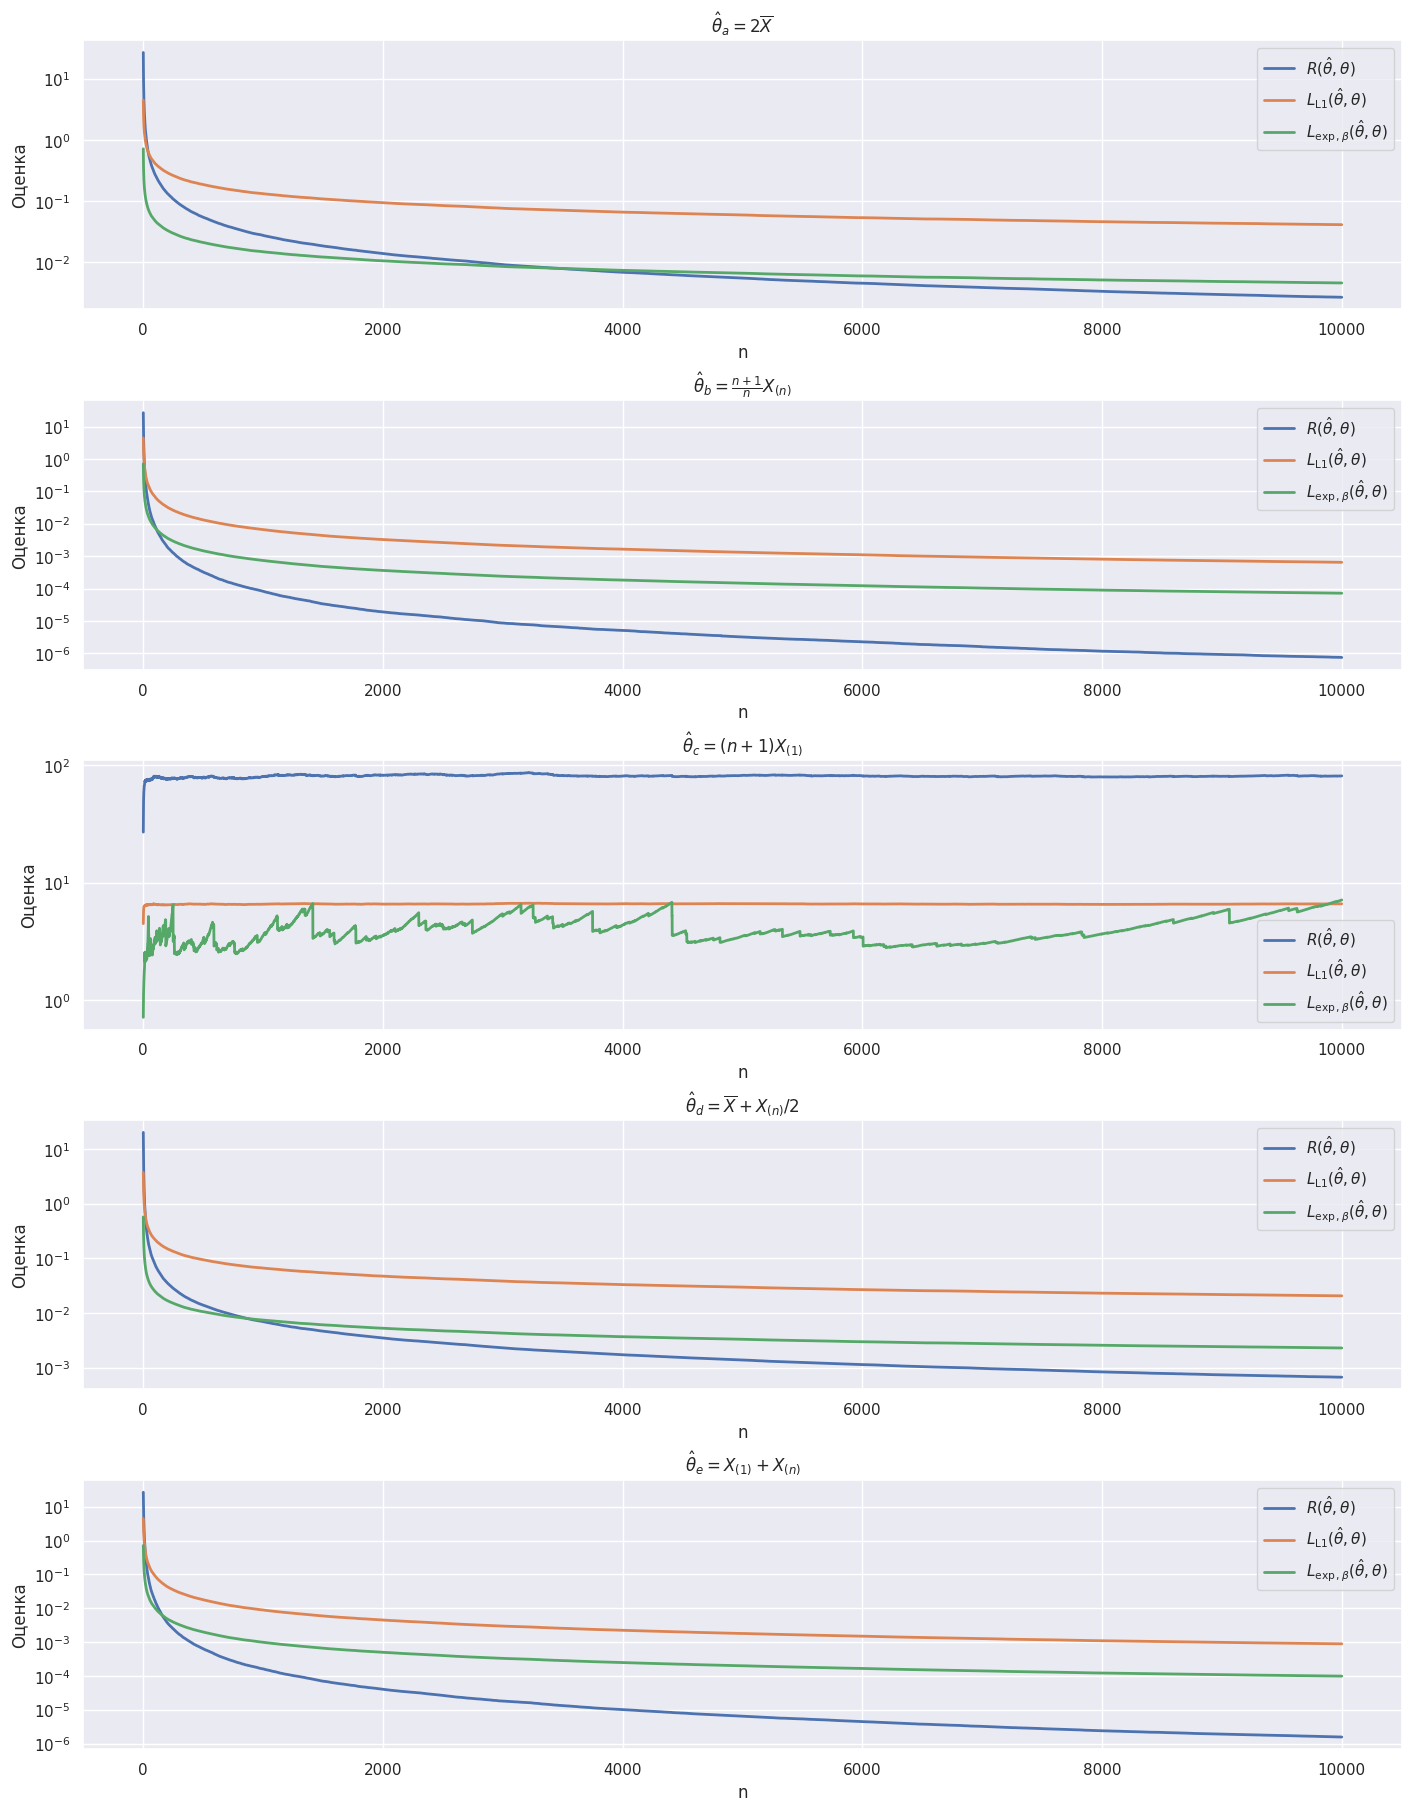

In [59]:
def R_L1_emp(X, th = THETA):
    return abs(X - th).mean(axis=0)

BETTA = 1 / THETA
def R_Lexp_emp(X, th = THETA, b = BETTA):
    return (np.exp(b * abs(X - th)) - 1).mean(axis=0)

L1_emp = [R_L1_emp(x) for x in distr]
Lexp_emp = [R_Lexp_emp(x) for x in distr]

fig, axes = plt.subplots(len(emp), 1, figsize=(14, 18), sharex=False, sharey=False, constrained_layout=True)
sns.set(style="darkgrid")
titles = [r"$\hat\theta_a = 2\overline{X}$", r"$\hat\theta_b = \frac{n+1}{n} X_{(n)}$", r"$\hat\theta_c = (n+1)X_{(1)}$", r"$\hat\theta_d = \overline{X} + X_{(n)}/2$", r"$\hat\theta_e = X_{(1)}+X_{(n)}$"]

for i in range(len(emp)):
    pos = axes.ravel()[i]
    pos.plot(n_range, emp[i], lw=2, alpha=1, label=r"$R(\hat{\theta},\theta)$")
    pos.plot(n_range, L1_emp[i], lw=2, alpha=1, label=r"$L_{\mathrm{L1}}(\hat{\theta},\theta)$")
    pos.plot(n_range, Lexp_emp[i], lw=2, alpha=1, label=r"$L_{\exp,\beta}(\hat{\theta},\theta)$")
    pos.legend(loc="best"); pos.set_xlabel(r"n"); pos.set_ylabel("Оценка"); pos.set_yscale("log")
    pos.set_title(titles[i])
plt.show()

<font color="#ae69c9ff">

Я рассмотрел следующие функции потерь:
- $R(\hat{\theta}, \theta) = E_\theta((\hat{\theta} - \theta)^2)$ - уже знакомая нам среднеквадратичная
- $L_{\mathrm{L1}}(\hat{\theta}, \theta) = E_\theta(|\hat{\theta} - \theta|)$ - абсолютная, должна быть менее чувствительной к высокой дисперсии
- $L_{\exp,\beta}(\hat{\theta}, \theta)=E_\theta(\exp(\beta, |\hat{\theta} - \theta|) - 1),\qquad \beta=1/\theta$ - экспоненциальная, должна быть более чувствительной к высокой дисперсии

Критерии выбора фунуций потерь:
- Функция монотонна по $|\hat{\theta}-\theta|$ - единственность экстремума
- Выпуклая по $\hat{\theta}$ - так привычнее
- $F(\hat{\theta},\theta) > 0, F(\theta, \theta) = 0$ - сам экстремум
- Обладают какой-то уникальной чувствительностью к дисперсии

<font color="#ae69c9ff">

Хочется сказать, что относительный порядок функций потерь остался прежним, но формально - нет. Для всех оценко сравнимы между собой только функции $R(\hat{\theta}, \theta)$ и $L_{\mathrm{L1}}(\hat{\theta}, \theta)$, и то, на разных оценках могут давать отличающиеся результат.\
Хотя это скорее исключение, если говорить в практическом смысле, рассматривать функции с большого n и исключить оценку $\hat\theta_c = (n+1)X_{(1)}$, то относительный порядок тот же.

6. До текущего момента мы сравнивали риск для конкретного значения параметра. Если для каждого значения параметра риск одной оценки оказывается лучше, чем другой, то первая оценка считается лучше в равномерном подходе. Хоть у нас именно этот случай и реализовался, это редкий случай. Часто оказывается, что для одних значений параметров одни оценки лучше других, а для других значений наоборот. В этом случае используют байесовский подход.

Предложите некоторую плотность распределений самого параметра, просемплируйте из неё 10-100 значений и посчитайте байесовский эмпирический риск. Байесовский риск это интеграл (в нашем случае среднее) риска при случайном значении параметра. Объясните, из каких прикладных соображений следует выбирать плотность распределения параметра?

In [60]:
def R_emp(X, th = THETA):
    return np.cumsum((X - th) ** 2) / n_range

def R_L1_emp(X, th = THETA):
    return np.cumsum(abs(X - th)) / n_range

BETTA = 1 / THETA
def R_Lexp_emp(X, th = THETA, b = BETTA):
    return np.cumsum(np.exp(b * abs(X - th)) - 1) / n_range

def plot_the_estimator_curves_for_the_supplied_parameter_distribution(thetas):
    N = len(thetas)
    samples = [sps.uniform(0, th).rvs(SAMPLE_SIZE, random_state=seed) for th in thetas]

    n_range = np.arange(1, SAMPLE_SIZE+1)
    Xa = 2 * np.cumsum(samples, axis=1) / n_range
    Xb = (n_range + 1) / n_range * np.maximum.accumulate(samples, axis=1)
    Xc = (n_range + 1) * np.minimum.accumulate(samples, axis=1)
    Xd = Xa / 2 + np.maximum.accumulate(samples, axis=1) / 2
    Xe = np.minimum.accumulate(samples, axis=1) + np.maximum.accumulate(samples, axis=1)
    distr = [Xa, Xb, Xc, Xd, Xe]

    R_com_emp = [np.array([R_emp(X[i], thetas[i]) for i in range(N)]).mean(axis=0) / N for X in distr]
    L1_emp = [np.array([R_L1_emp(X[i], thetas[i]) for i in range(N)]).mean(axis=0) / N for X in distr]
    Lexp_emp = [np.array([R_Lexp_emp(X[i], thetas[i]) for i in range(N)]).mean(axis=0) / N for X in distr]

    fig, axes = plt.subplots(len(R_com_emp), 1, figsize=(14, 18), sharex=False, sharey=False, constrained_layout=True)
    sns.set(style="darkgrid")
    titles = [r"$\hat\theta_a = 2\overline{X}$", r"$\hat\theta_b = \frac{n+1}{n} X_{(n)}$", r"$\hat\theta_c = (n+1)X_{(1)}$", r"$\hat\theta_d = \overline{X} + X_{(n)}/2$", r"$\hat\theta_e = X_{(1)}+X_{(n)}$"]

    for i in range(5):
        pos = axes.ravel()[i]
        pos.plot(n_range, R_com_emp[i], lw=2, alpha=1, label=r"$R(\hat{\theta},\theta)$")
        pos.plot(n_range, L1_emp[i], lw=2, alpha=1, label=r"$L_{\mathrm{L1}}(\hat{\theta},\theta)$")
        pos.plot(n_range, Lexp_emp[i], lw=2, alpha=1, label=r"$L_{\exp,\beta}(\hat{\theta},\theta)$")
        pos.legend(loc="best"); pos.set_xlabel(r"n"); pos.set_ylabel("Оценка"); pos.set_yscale("log"); pos.set_xscale("log")
        pos.set_title(titles[i])
    plt.show()

Оценки для равномерного распределения параметра:

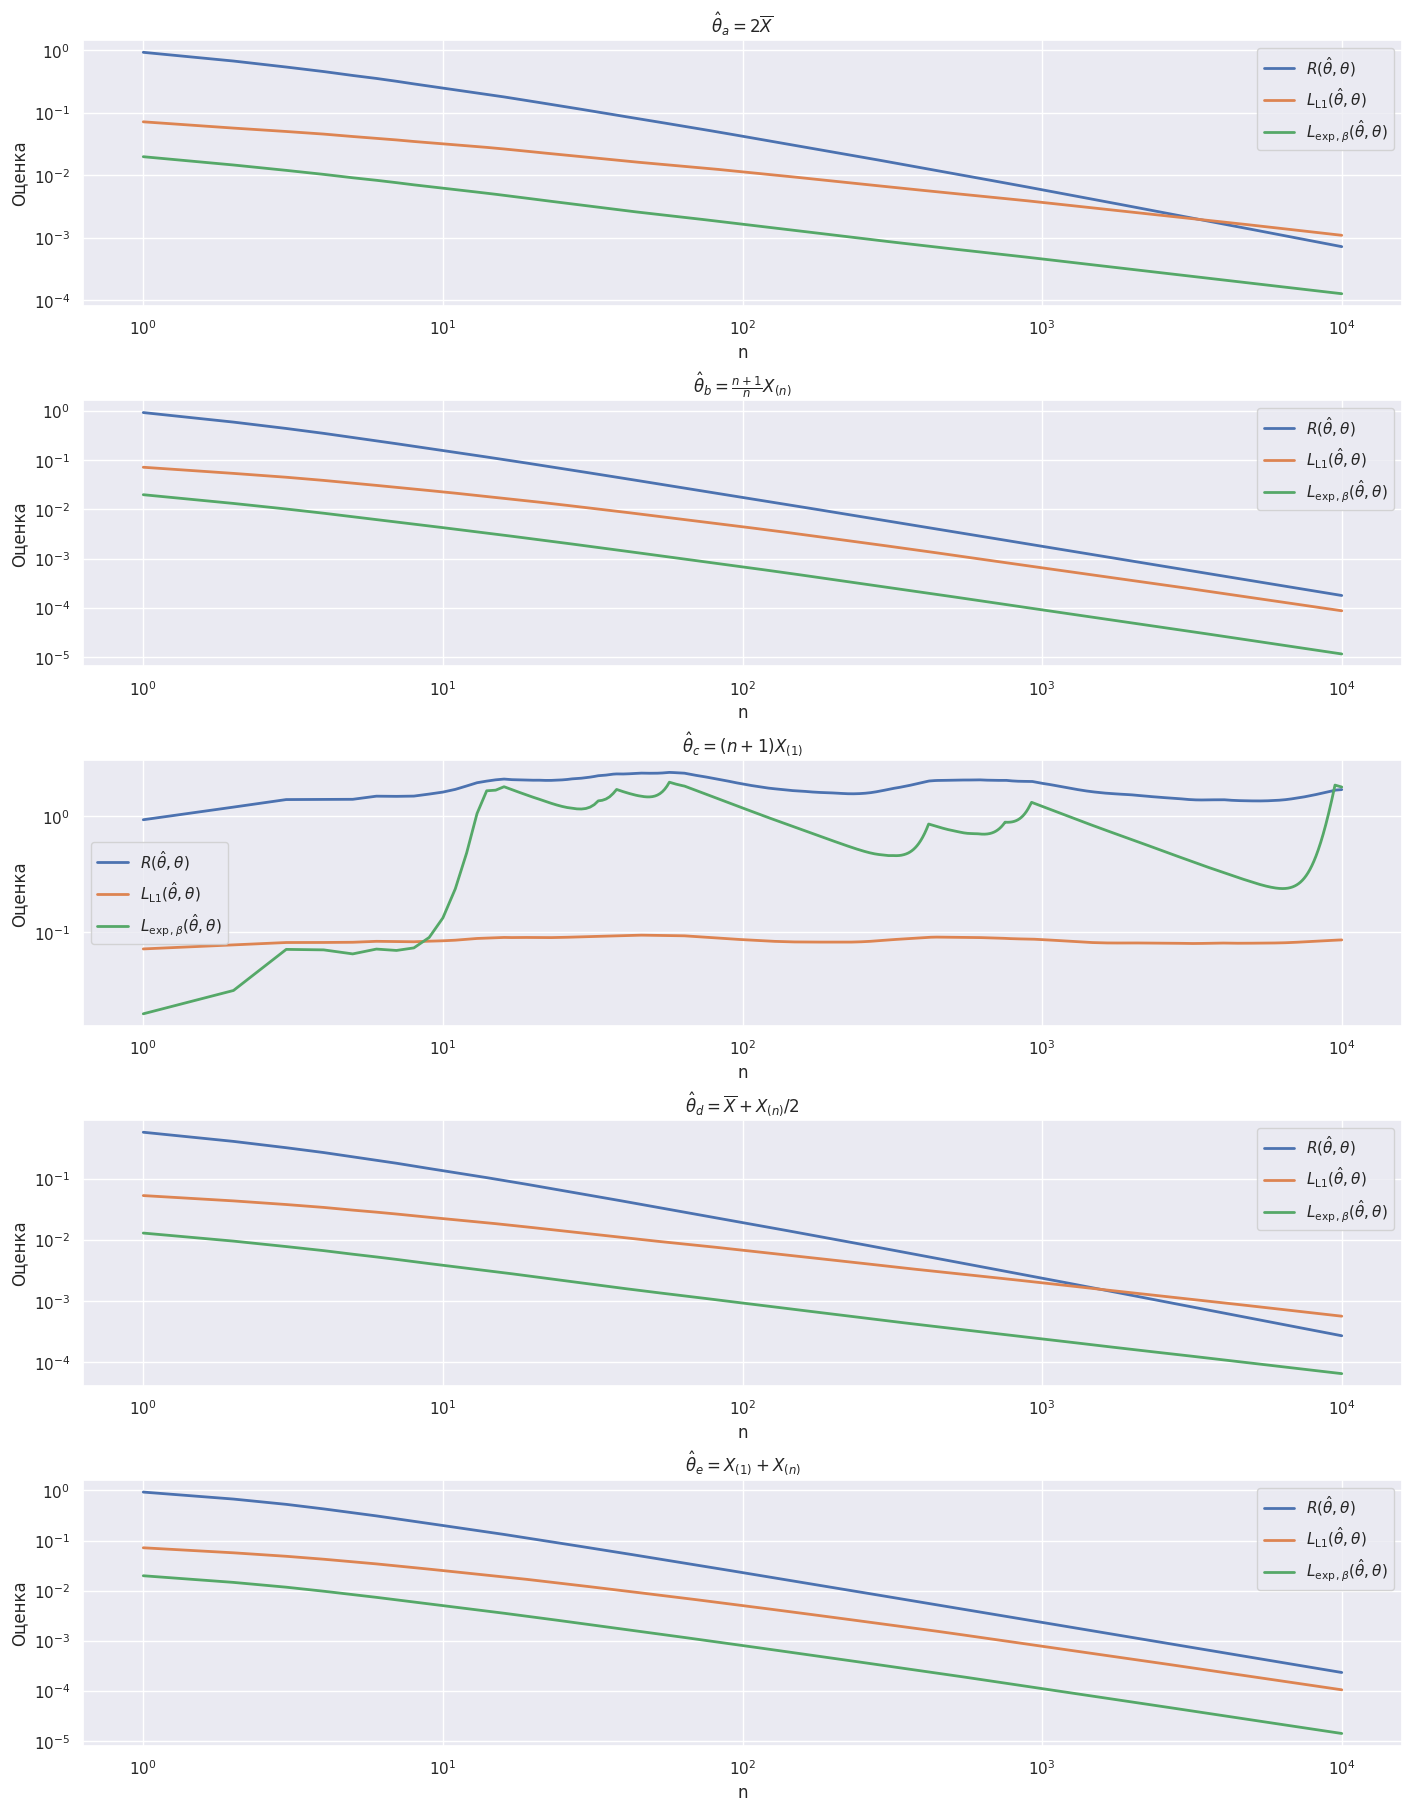

In [61]:
N = 100
plot_the_estimator_curves_for_the_supplied_parameter_distribution(sps.uniform(0, 3*THETA).rvs(N, random_state=seed))

<font color="#ae69c9ff">

Оценки для распределения парето параметра:

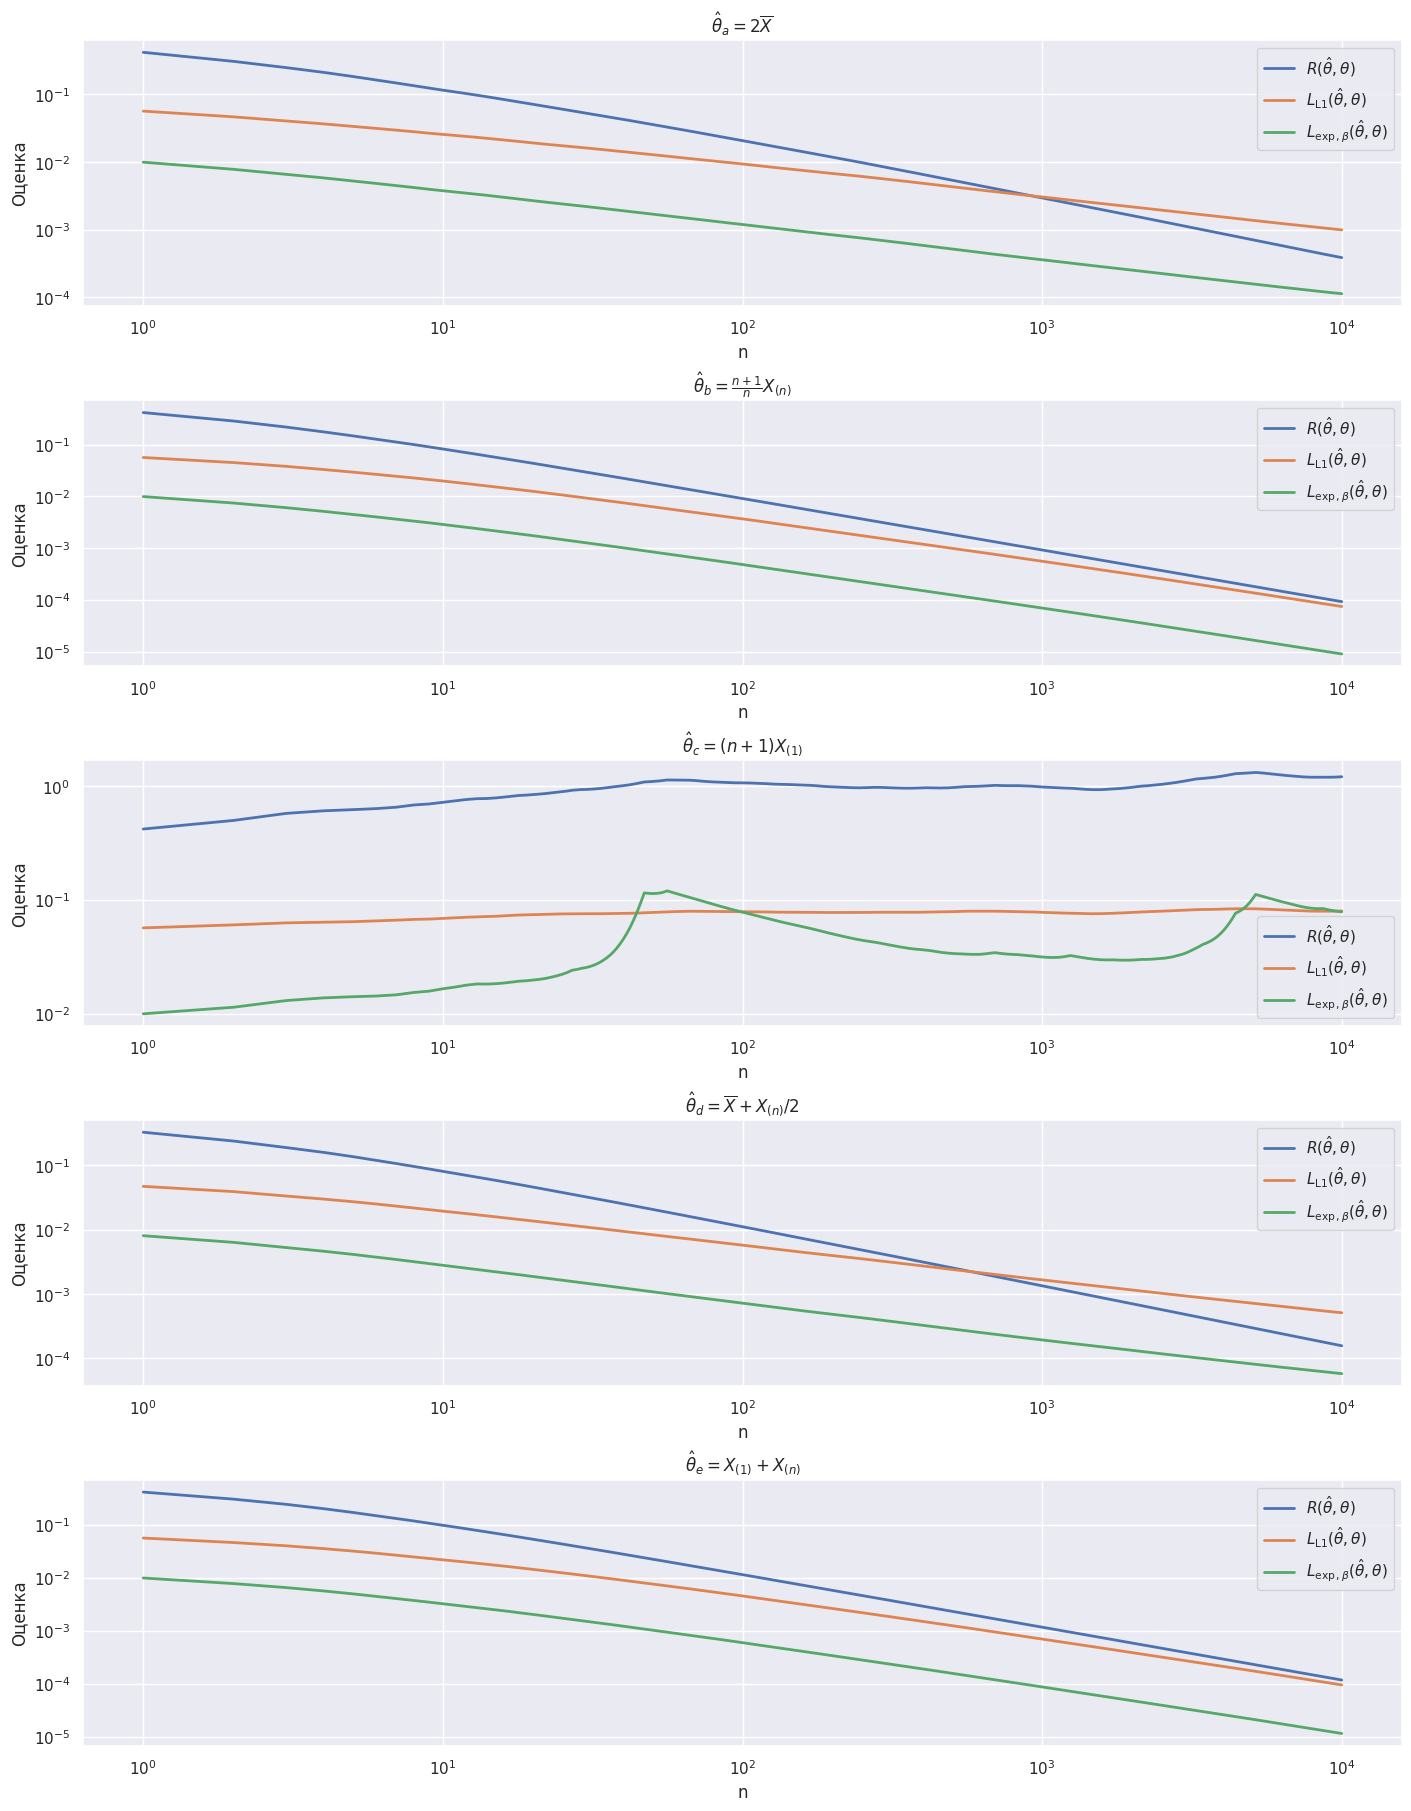

In [62]:
plot_the_estimator_curves_for_the_supplied_parameter_distribution(sps.pareto(2, 9).rvs(N, random_state=seed))

<font color="#ae69c9ff">

Оценки для экспоненциального распределения параметра:

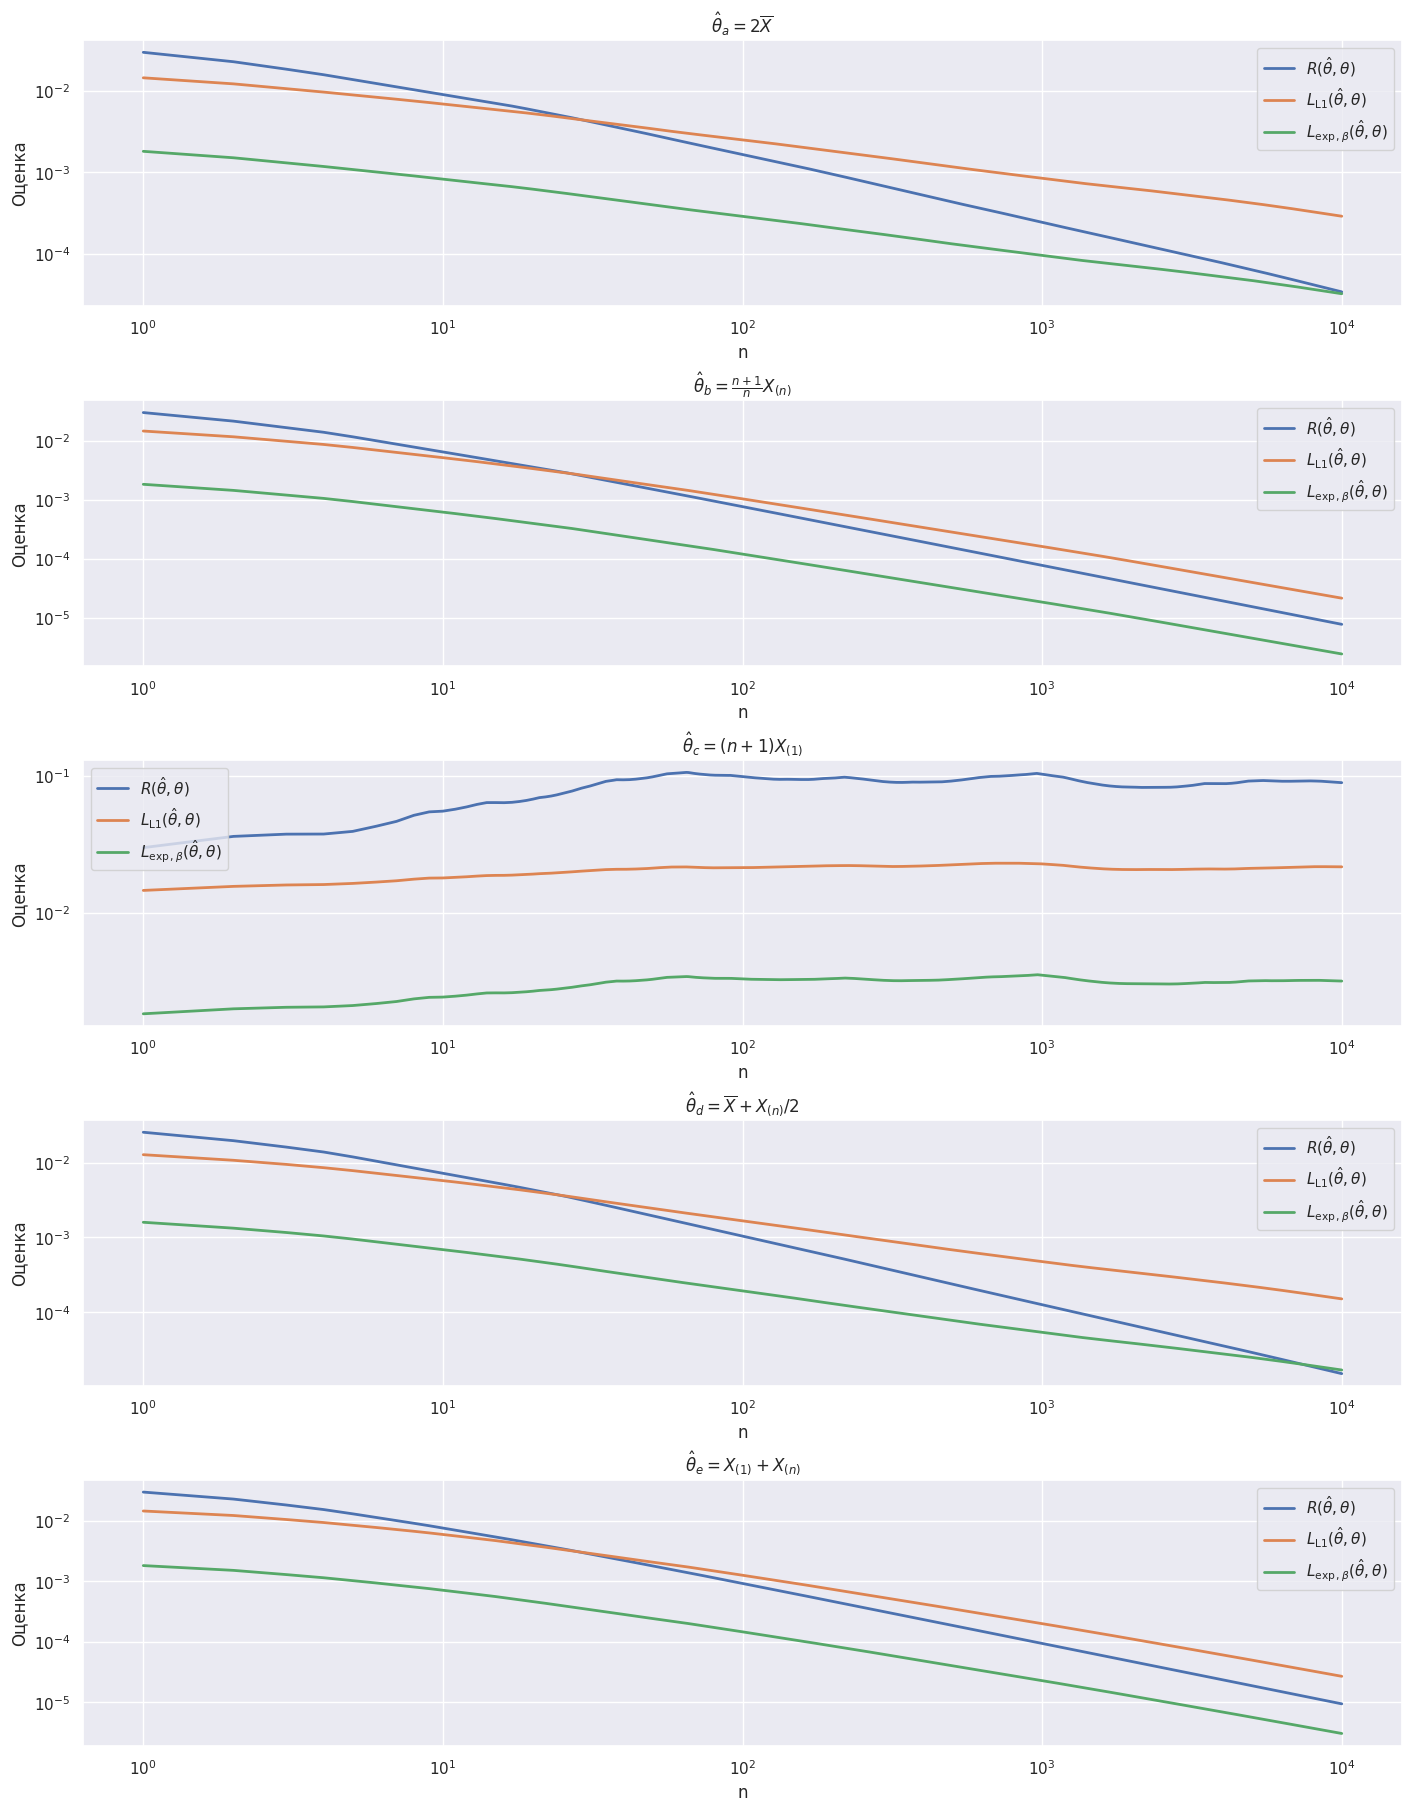

In [63]:
plot_the_estimator_curves_for_the_supplied_parameter_distribution(sps.expon(2).rvs(N, random_state=seed))

<font color="#ae69c9ff">

На стене в болтае я прочитал, что стоит взять следующие распределения оценок:
- классическое равномерное распределение, границы которого немого шире рассматриваемого ранее - т.к. это что-то знакомое
- распределение парето - актуально, когда мы верим в существование какой-то нижней границы и знаем, что хвост справа убывает медленно
- экспоненциальное распределение - если мы верим, что параметр преимущественно мал

Как я понял, выбираем распределение мы на основе предположений о значении искомого параметра. В случае +- точного угадывания, большее количество "нужных"/"интересных" оценок внесут высокий вклад в итоговое значение функции ошибки

<span style="color:red">Хорошие ссылки на источники</span>

Сделайте выводы о том, какая оценка оказалась лучше. В выводе отметьте, с какой скоростью сходились точные риски первых трёх оценок и как это влияет на точность оценки.

<font color="#ae69c9ff">

Лучше всего себя показала оценка $\hat\theta_b = \frac{n+1}{n} X_{(n)}$, хуже всего $\hat\theta_c = (n+1)X_{(1)}$.

Про скорость сходимости первых трё оценок: скорость сходимости следует напрямую из теоретических оценок (см выше), на практике она подтвердилась -> победа!\
Первая оценка убывает линейно, вторая - квадратично, а третья - не убывает вовсе.

Влияние на точность: чем быстрее убывает оценка, тем выше точность. Выше был вывод, что первая оценка является суммой дисперсии и квадратом смещения, для 2 и 3 - тоже описал 

### Задача 4

В этой задаче мы проверим теорему Гливенко-Кантелли, как результат, гарантирующий что эмпирически посчитанные величины хорошо приближают теоретические.

В этой задаче Вам предстоит:
- Построить эмпирическую функцию распределения для разных размеров выборки и сравнить её с теоретической функцией.
- Построить одну из ключевых статистик: статистику Колмогорова и изучить её предельные свойства

1. Для стандартного нормального распределения сгенерируйте 10000 выборок размера 10000. Для каждой выборки посчитайте эмпирическую функцию распределения для некоторой сетки. Напомним, что эмпирическая функция распределения (ЭФР) это $\hat{F}(x) = \frac{1}{n}\sum\limits_{i=1}^n I(x \leq X_i)$, где $X_i$ это элемент выборки.

<font color="#ae69c9ff">

Дорогой дневник, сегодня я ~напакостил~ выделил 70Гб с SSD на подкачку, так как мне не хватило 32Гб оперативной памяти для подсчёта распределения на выборке из 5000 элементов. 10000 элементов я обработать не смогу.\
Буду рад узнать алгос, которым это делается!

P.S. Я сначала посчитал +- нормальным методом, из-за того, что не уложился бы во время для 10к элементов, посчитал оценку $\sup\limits_{x \in \mathbb{R}}|\hat{F}(x) - F(x)| \leqslant \max_{1 \leqslant k < n}{ \max{( |F(X_{(k)}) - \frac{k}{n}|, | F(X_{(k+1)}) - \frac{k}{n} | )} }$ и расписал в латехе её вывод, но и здесь меня постигла неудача. Как итог - принял решение, описанное выше, чтобы построить зелёное облако ниже. Вроде как этого можно было не делать, получается. Пожалуйста, пишите тз понятнее!

In [64]:
SAMPLE_SIZE = 5000
N = 100
samples = sps.norm(0, 1).rvs((SAMPLE_SIZE, SAMPLE_SIZE), random_state=seed)
n_range = np.arange(1, SAMPLE_SIZE+1)
grid = np.linspace(-5, 5, N)

D_n = np.max(np.array([abs(np.cumsum(samples <= x, axis=1) / n_range - sps.norm.cdf(x)) for x in grid]), axis=0)
print(D_n)

[[0.63815644 0.47985996 0.32471814 ... 0.00944636 0.00956443 0.00948245]
 [0.97556344 0.47556344 0.34194852 ... 0.01421743 0.01434967 0.01448186]
 [0.67528186 0.35556552 0.47138215 ... 0.01241373 0.01249922 0.01238468]
 ...
 [0.67528186 0.67528186 0.52014004 ... 0.00813524 0.00823766 0.00814004]
 [0.8313707  0.47985996 0.47985996 ... 0.00515949 0.00523853 0.00531755]
 [0.74426988 0.74426988 0.56021532 ... 0.01099563 0.01090546 0.01081532]]


Для некоторых размеров выборки (лучше не больше 6 разных) постройте на графике ЭФР и теоретическую функцию распределения. Как ведёт себя ЭФР с ростом параметра?

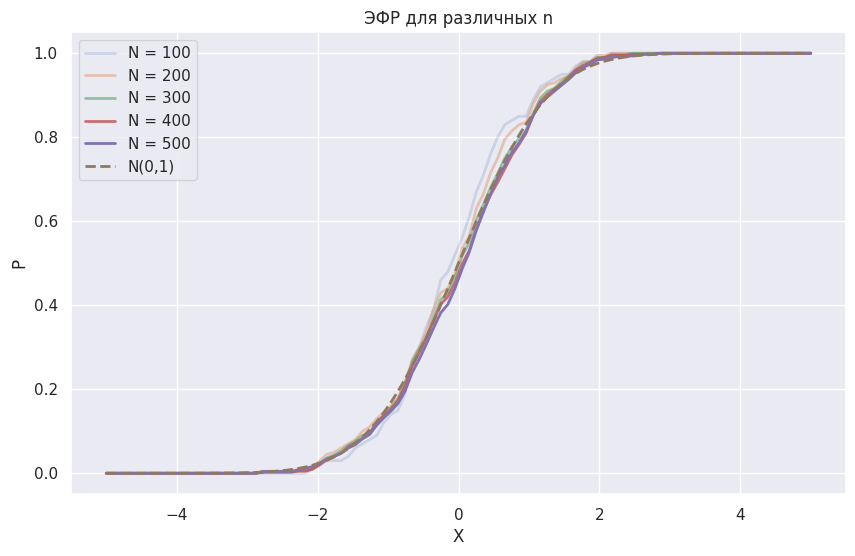

In [65]:
SAMPLE_SIZE = 500
N = 5
ns = [int((n + 1) / N * SAMPLE_SIZE - 1) for n in range(N)]
F_n = np.array([np.cumsum(samples[:N, :] <= x, axis=1) / n_range for x in grid])

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
for n in range(len(ns)):
    plt.plot(grid, F_n[:, 0, ns[n]], lw=2, alpha=(n + 1)/5, label="N = "+str(ns[n] + 1))
plt.title("ЭФР для различных n")
plt.plot(grid, sps.norm.cdf(grid), linestyle="--", lw=2, label="N(0,1)")
plt.xlabel("X"); plt.ylabel("P"); plt.legend(loc="best"); plt.grid(True)
plt.show()

<span style="color:red">ЭФР --- кусочно-постоянная, а не кусочно-линейная (-1)</span>

<font color="#ae69c9ff">

Уже для N = 300 наблюдается "хорошая" сходимость к N(0, 1), дальше функция сходится всё лучше и лучше.

Теорема Гливенко-Кантелли утверждает, что $D_n = \sup\limits_{x \in \mathbb{R}}|\hat{F}(x) - F(x)|$ стремится к нулю почти наверное. Посчитайте, чему равен этот супремум численно и как он себя ведёт с ростом $n$. Проверили ли мы теорему?

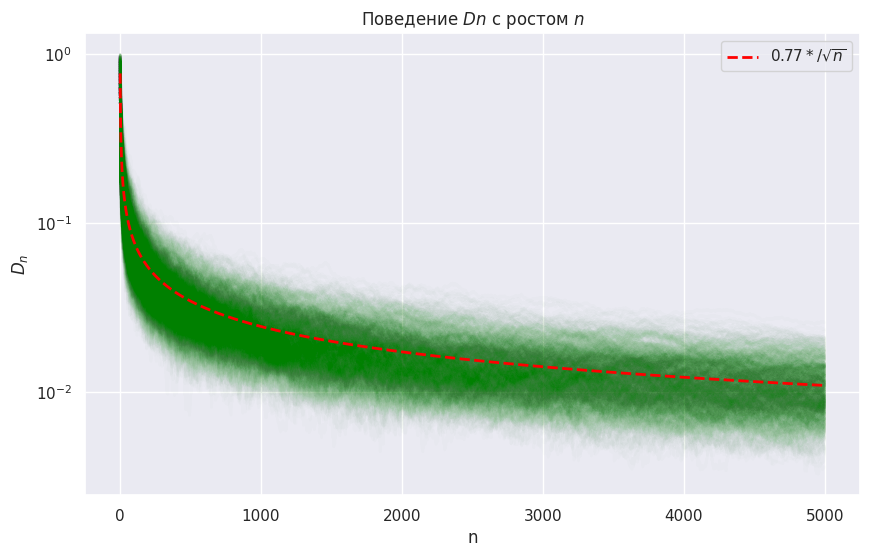

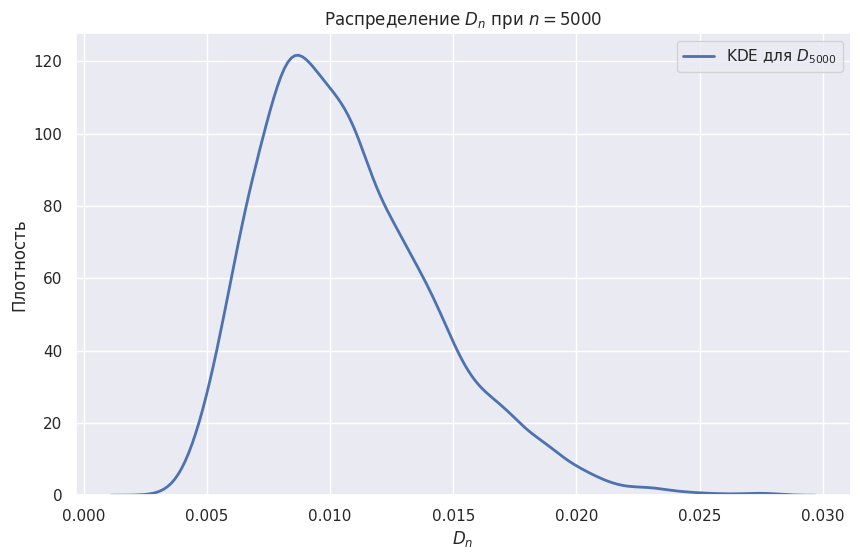

In [66]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
[plt.plot(n_range, D_n[i, :], lw=2, color="green", alpha=0.01) for i in range(1000)]
plt.title(r"Поведение $Dn$ с ростом $n$")
plt.plot(n_range, 0.77 / np.sqrt(n_range), linestyle="--", lw=2, color="red", label=r"$0.77*/\sqrt{n}$")
plt.xlabel("n"); plt.ylabel(r"$D_n$"); plt.yscale("log"); plt.legend(loc="best"); plt.grid(True)
plt.show()

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.kdeplot(D_n[:, -1], lw=2, label=r"KDE для $D_{5000}$")
plt.title(r"Распределение $D_n$ при $n = 5000$")
plt.xlabel(r"$D_n$"); plt.ylabel("Плотность"); plt.legend(loc="best"); plt.grid(True)

<font color="#ae69c9ff">

$D_n$ действительно стремится к нулю и делает это примерно со скоростью 1/$\sqrt{n}$. Что примечательно, $D_n$ имеет некоторое распределение при убывании. _Окак, я обратил внимание на что-то важное (задания делались итеративно)_

*константа подобрана, чтобы пунктирная линия была примерно по центру "облака".

Промоделируйте статистику $\sqrt{n}D_n$ для n = 10000 и постройте её KDE. Затем промоделируйте эту же статистику не для нормального распределения, а для 3 других любых предложенных Вами распределений. Если вычисления застрянут, можете уменьшить число выборок или размер выборки. Будет ли итоговая плотность такой же?

In [67]:
SAMPLE_SIZE = 5000
N = 100
n_range = np.arange(1, SAMPLE_SIZE+1)

samples_1 = sps.cauchy(0, 0.5).rvs((SAMPLE_SIZE, SAMPLE_SIZE), random_state=seed)
samples_2 = sps.laplace(2, 3).rvs((SAMPLE_SIZE, SAMPLE_SIZE), random_state=seed)
samples_3 = sps.gamma(2, 1).rvs((SAMPLE_SIZE, SAMPLE_SIZE), random_state=seed)
grid = np.linspace(-5, 5, N)

D_n_seq = []
samples_seq = [samples_1, samples_2, samples_3]
cdf_seq = [lambda x: sps.cauchy(0, 0.5).cdf(x),
           lambda x: sps.laplace(2, 3).cdf(x),
           lambda x: sps.gamma(2, 1).cdf(x)]
grids_seq = [np.linspace(-15, 15, N), np.linspace(-15, 15, N), np.linspace(0, 20, N)]
for i in range(3):
    D_n_seq.append(np.max(np.array([abs(np.cumsum(samples_seq[i] <= x, axis=1) / n_range - cdf_seq[i](x)) for x in grid]), axis=0))

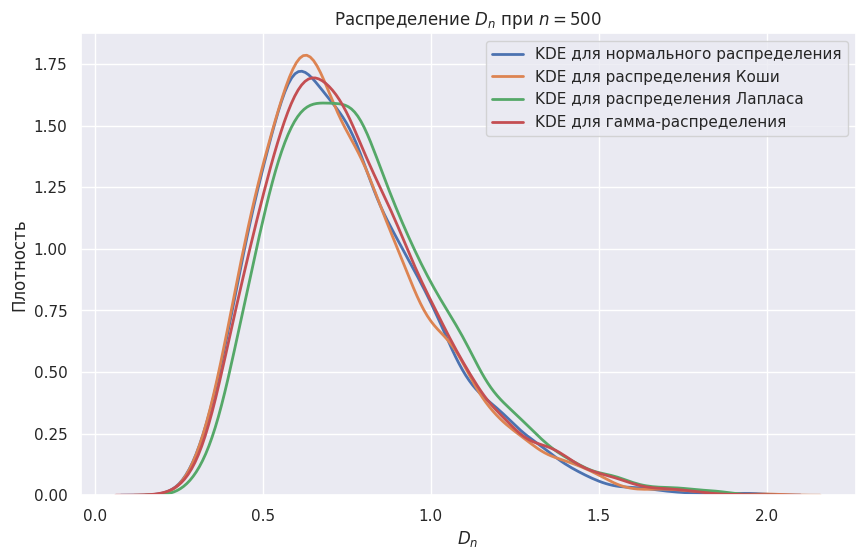

In [68]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")

D_n_seq_1 = [D_n, *D_n_seq]
labels = ["KDE для нормального распределения", "KDE для распределения Коши",
          "KDE для распределения Лапласа", "KDE для гамма-распределения"]

sns.set(style="darkgrid")

for i in range(4):
    sns.kdeplot(D_n_seq_1[i][:, -1]*SAMPLE_SIZE**0.5, lw=2, label=labels[i])

plt.legend(loc="best"); plt.xlabel(r"$D_n$"); plt.ylabel("Плотность"); plt.title(r"Распределение $D_n$ при $n = 500$")
plt.show()

<font color="#ae69c9ff">

Круто!! На графиках видно, что полученные распределения для n реализаций выборок соответствующих распределений практически совпадают. Это говорит об одинаковой природе распределения и о том, что она не зависит от выбора исходного распределения элементов выборки.

На просторах интернета, в беседе с умными людьми или на скале в пещере найдите, к чему сходится по распределению статистика $\sqrt{n}D_n$? Какое есть применение у этого крупного результата?

<font color="#ae69c9ff">

На стене в болтае написано, что эта штука в пределе сходится к распределению Колмогорова. Как мы уже поняли, оно замечательно тем, что не зависит от исходного распределения элементов выборки.
Получило логическое продолжение в следующих темах/задачах/методах:
- Критерий согласия Колмогорова (проверка распределений на согласованность/соответствие)
- Построение равномерных доверительных интервалов для плотностей


Если Вы нашли ответ на вопрос выше, проверьте что Ваше распределение совпадает с теоретическим пределом при помощи QQ-plot

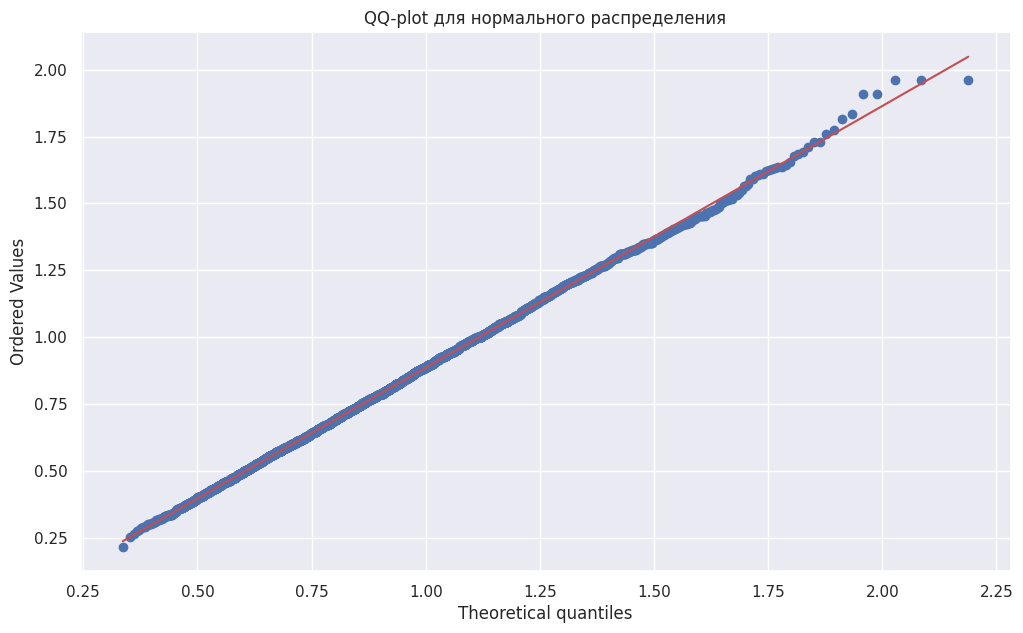

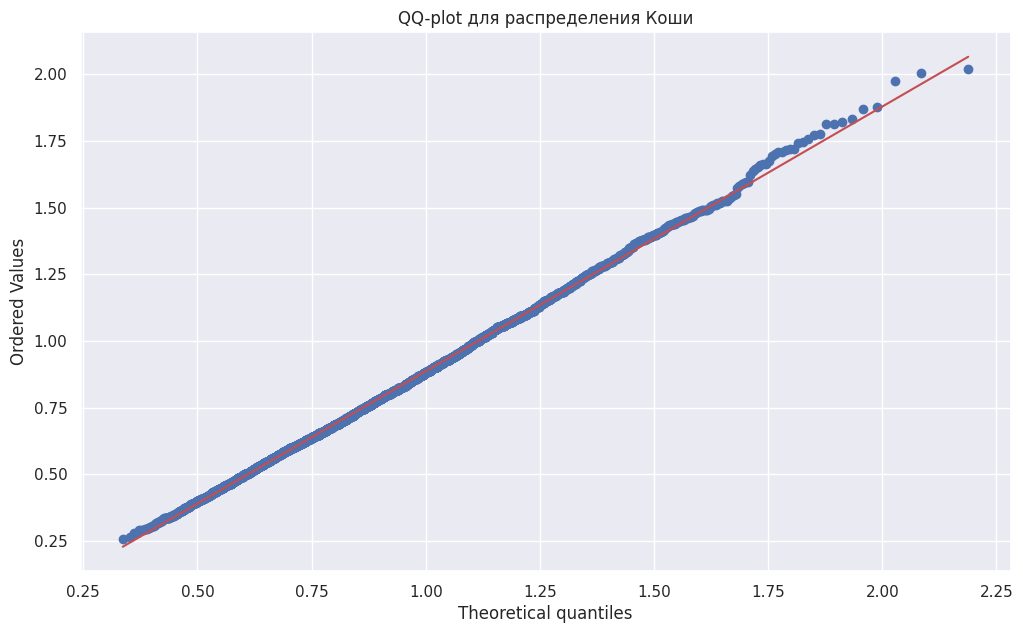

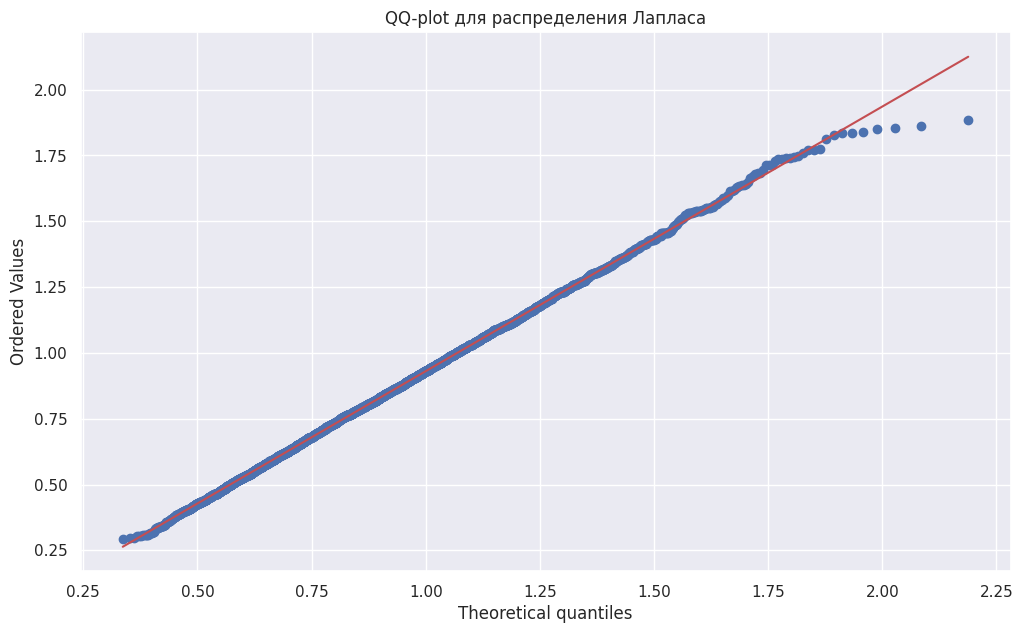

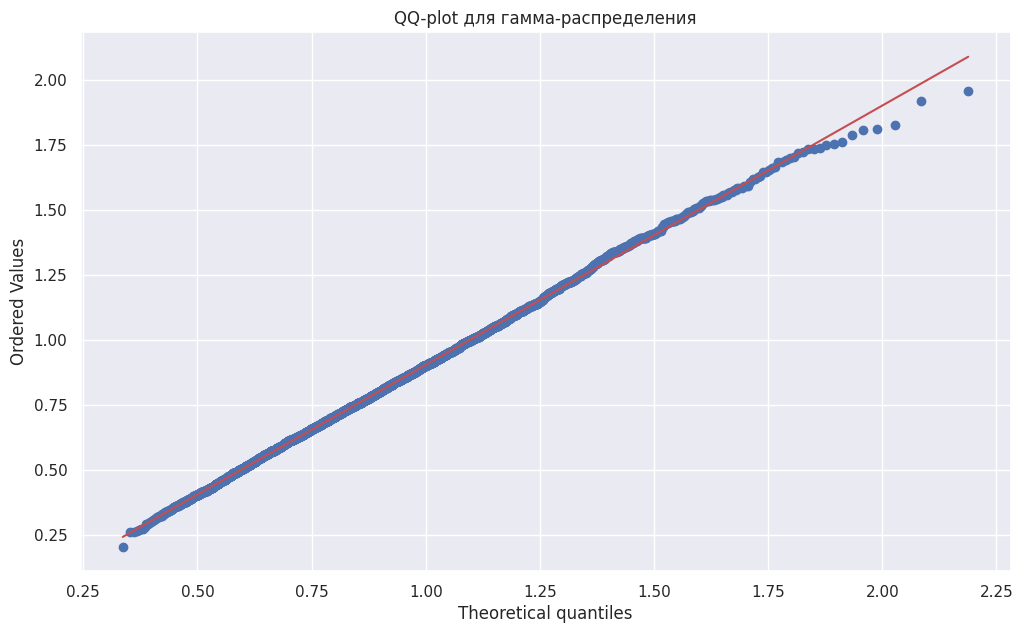

In [69]:
sns.set(style="darkgrid")
labels = ["QQ-plot для нормального распределения", "QQ-plot для распределения Коши", "QQ-plot для распределения Лапласа",
          "QQ-plot для гамма-распределения"]

D_n_seq_1 = [D_n, *D_n_seq]
for i in range(4):
    plt.figure(figsize=(12, 7))
    _ = sps.probplot(D_n_seq_1[i][:, -1]*SAMPLE_SIZE**0.5, dist=sps.kstwobign, plot=plt)
    plt.title(labels[i])

plt.show()

<font color="#ae69c9ff">

Круто!! На основе qq-plot можно заключать, что я был прав в предположении сходимости распределений к распределению Колмагорова.
На всех графиках наблюдаются малые флуктуации правого хвоста; я считаю, это обосновано малым количеством выборок и в принципе небольшим количеством элементов в них.

### Задача 5

В этой задаче мы проверим предельные свойства оценок и познакомимся с таким понятием как гипернормальная сходимость.

В этой задаче Вам предстоит:
- Изучить предельные распределения и скорости сходимости разных оценок
- Понять как теоретические результаты могут предложить гарантию качества на практике

1. Сгенерируйте $N=400$ выборок из равномерного распределения $\mathrm U{[0, \theta]}$ для $\theta=9$ размера $n=40$. Посчитайте оценки $\hat\theta = 2\overline{X}, \ \theta^* = \frac{n+1}{n} X_{(n)}$ и нарисуйте их KDE на одном графике.

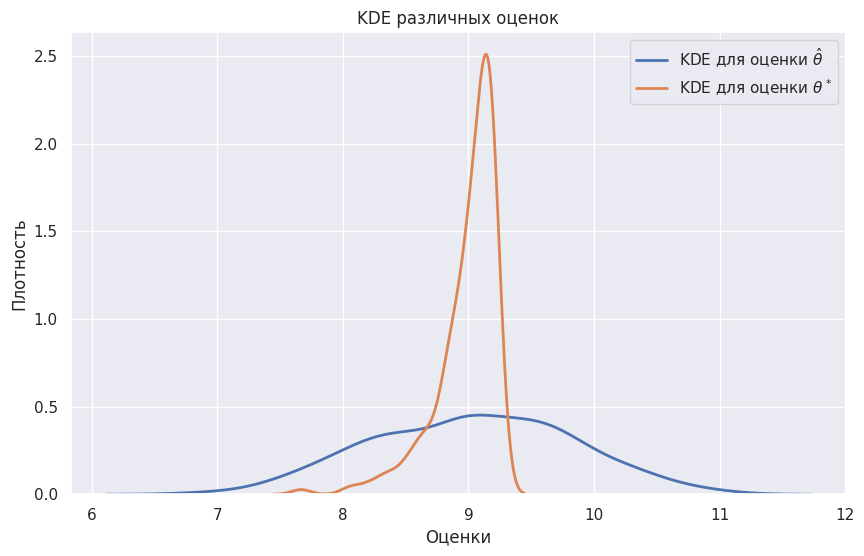

In [70]:
SAMPLE_SIZE = 40
N = 400
THETA = 9

samples = sps.uniform(0, THETA).rvs((N, SAMPLE_SIZE), random_state=seed)
n_range = np.arange(1, SAMPLE_SIZE+1)

theta_hat = 2 * np.cumsum(samples, axis=1) / n_range
theta_star = (n_range + 1) / n_range * np.maximum.accumulate(samples, axis=1)

plt.figure(figsize=(10,6))
sns.set(style="darkgrid")

sns.kdeplot(theta_hat[:, -1], lw=2, label=r"KDE для оценки $\hat{\theta}$")
sns.kdeplot(theta_star[:, -1], lw=2, label=r"KDE для оценки $\theta^*$")
plt.legend(loc="best"); plt.xlabel(r"Оценки"); plt.ylabel("Плотность"); plt.title("KDE различных оценок")
plt.show()

2. Численно и визуально проверьте, что обе оценки сходятся по вероятности к своему параметру.

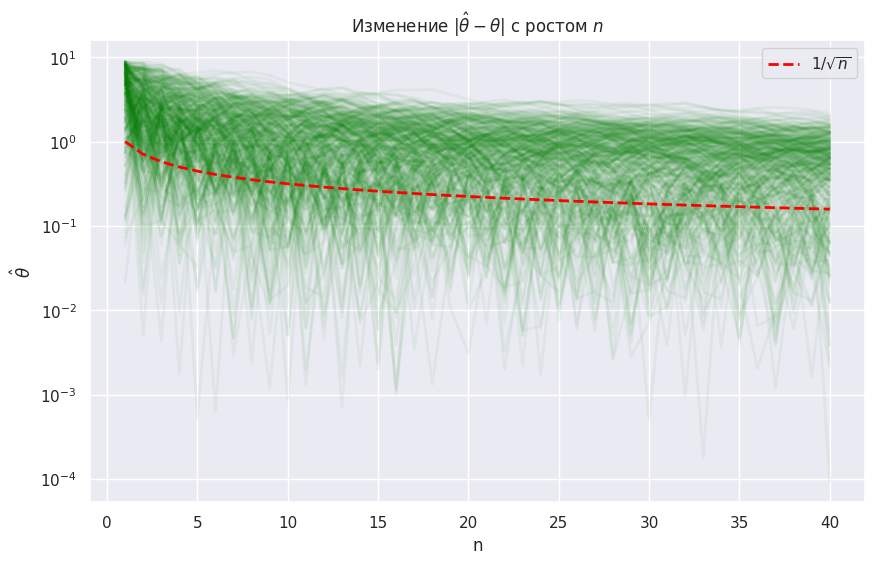

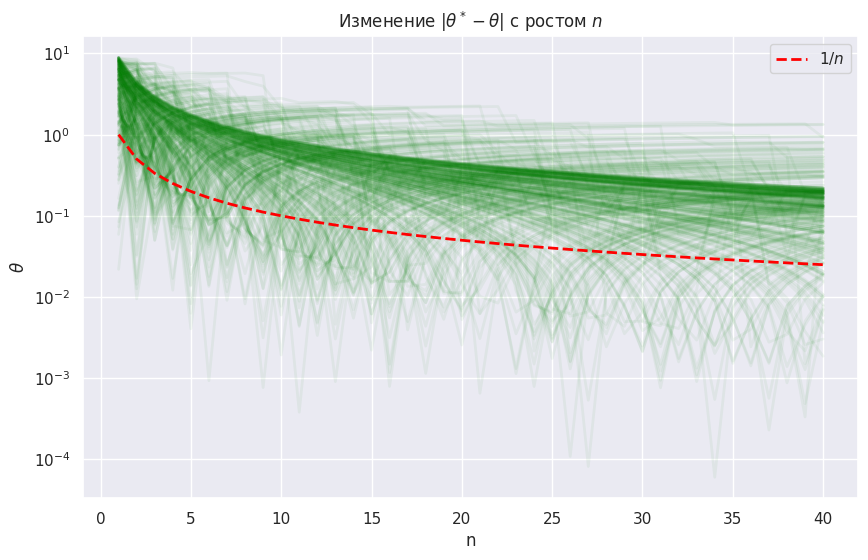

In [71]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
[plt.plot(n_range, abs(theta_hat[i, :] - THETA), lw=2, color="green", alpha=0.05) for i in range(N)]
plt.title(r"Изменение $|\hat{\theta} - \theta|$ с ростом $n$")
plt.plot(n_range, 1/np.sqrt(n_range), linestyle="--", lw=2, color="red", label=r"$1/\sqrt{n}$")
plt.xlabel("n"); plt.ylabel(r"$\hat{\theta}$"); plt.yscale("log"); plt.legend(loc="best"); plt.grid(True)
plt.show()

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
[plt.plot(n_range, abs(theta_star[i, :] - THETA), lw=2, color="green", alpha=0.05) for i in range(N)]
plt.title(r"Изменение $|\theta^* - \theta|$ с ростом $n$")
plt.plot(n_range, 1/n_range, linestyle="--", lw=2, color="red", label=r"$1/n$")
plt.xlabel("n"); plt.ylabel(r"$\theta$"); plt.yscale("log"); plt.legend(loc="best"); plt.grid(True)
plt.show()

<font color="#ae69c9ff">

Проверка осуществляется по методу, идентичному 1.4, сделал всё описанное там. На графиках заметно отсутствие выбросов вверх, характер скорости убывания кривых совпадает с кривыми, нанесёнными пунктиром (пока без явного вычисления константы, скорость сходимости взята с разборов на семинаре по мат.стат.). Выбросы вниз случаются, они явно видны из-за логарифмической шкалы по оси y, они появляются из-за того, что иногда оценка параметра "перешагивает" через 0, а у меня взят модуль при построении.

3. Промоделируйте статистики $\sqrt{n} (\hat\theta - \theta)$ и $\theta - n  (\theta^* - \theta)$. К чему сходятся их распределения с ростом $n$?

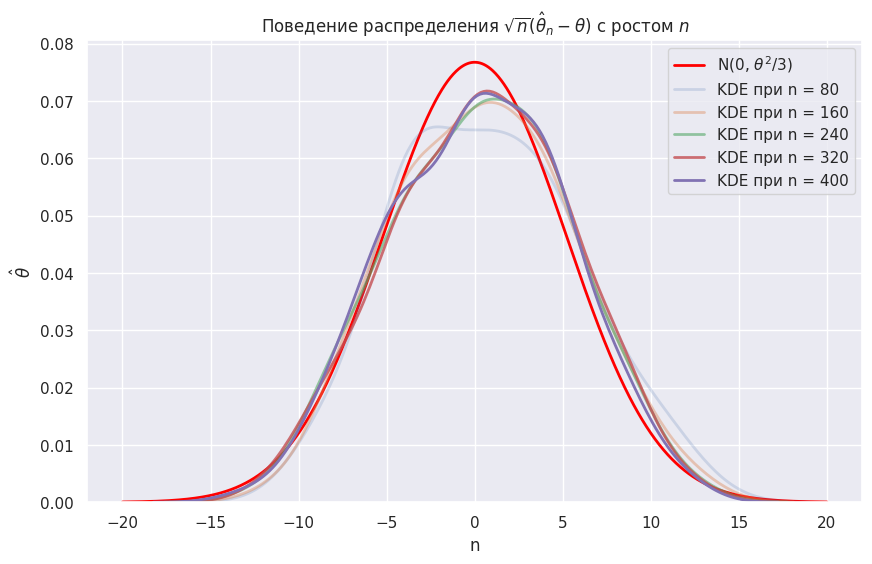

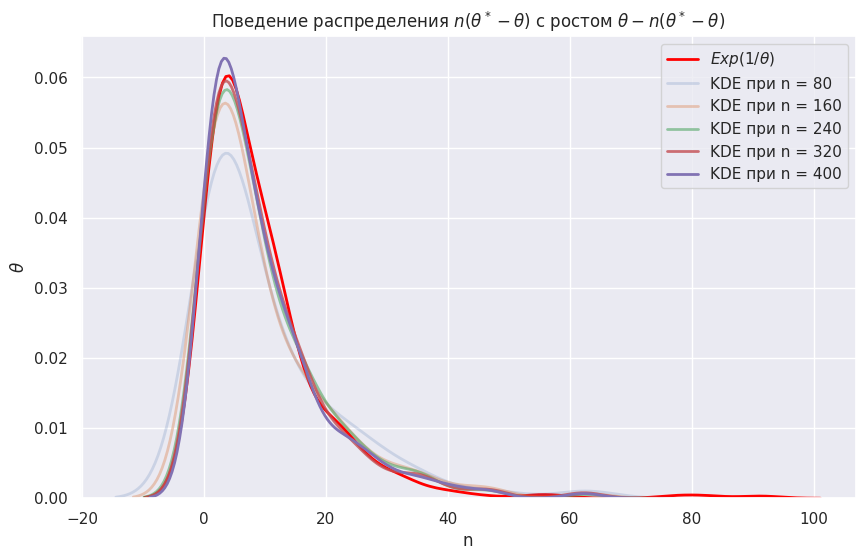

In [72]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))

ns = np.arange(1, 6) * int(N / 5)

plt.plot(np.linspace(-20, 20, 1000), sps.norm(0, (THETA**2 / 3) ** 0.5).pdf(np.linspace(-20, 20, 1000)), lw=2, c="red", label=r"N(0, $\theta^2/3)$")
[sns.kdeplot(((theta_hat - THETA) * np.sqrt(n_range))[:n, -1], alpha=n/N, lw=2, label=r"KDE при n = " + str(n)) for n in ns]
plt.title(r"Поведение распределения $\sqrt{n} (\hat{\theta}_n - \theta)$ с ростом $n$")
plt.xlabel("n"); plt.ylabel(r"$\hat{\theta}$"); plt.legend(loc="best"); plt.grid(True)
plt.show()

sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.kdeplot(sps.expon(scale=THETA).rvs(N), lw=2, c="red", label=r"$Exp(1/\theta)$")
[sns.kdeplot((THETA - (theta_star - THETA) * n_range)[:n, -1], lw=2, alpha=n/N, label=r"KDE при n = " + str(n)) for n in ns]
plt.title(r"Поведение распределения $n(\theta^* - \theta)$ с ростом $\theta - n  (\theta^* - \theta)$")
plt.xlabel("n"); plt.ylabel(r"$\theta$"); plt.legend(loc="best"); plt.grid(True)
plt.show()

<font color="#ae69c9ff">

С первым тривиально:
$\sqrt{n}(\hat{\theta}_n - \theta) = \sqrt{n} \left( \frac{\sum_{i=1}^{n} X_i}{n} - \theta \right) = \sqrt{n} \left( \frac{\sum_{i=1}^{n} (X_i - \theta)}{n} \right), \ E(X_i) = \theta,$ воспользуемся ЦПТ:
$\sqrt{n}\,(\hat{\theta}_n - \theta) \xrightarrow[n\to\infty]{} \mathcal{N}\!\bigl(0,\, D X_i\bigr)
= \mathcal{N}\!\left(0,\, \theta^{2}/3\right).$\
\
Со вторым тоже не очень сложно:
$\theta - n(\theta^* - \theta) = \theta-((n+1)X_{n}-n\theta)=(n+1)(\theta-X_{n})$\
$P\left( (n+1)(\theta-X_{n}) \leqslant x \right) = P\left( \theta-X_{n} \leqslant \frac{x}{n+1} \right) = 1 - P\left( X_{n} \leqslant \frac{(n+1)\theta-x}{n+1} \right) = 1 - \left( \frac{(n+1)\theta-x}{\theta(n+1)} \right)^n = 1 - \left( 1 - \frac{x/\theta}{n+1} \right)^n = 1 - e^{-1/\theta}$, так как функция распределения однозначно соответствует распределению, то: $\theta - n(\theta^* - \theta) \sim Exp(1/\theta)$\
\
Красота, графики отлично сходятся к теоретически полученным результатам, счастье.\
_Окак, здесь не нужно было выводить... Ну, ладно, пусть останется._

4. Проверьте Ваши догадки при помощи QQ-plot. Для этого предложите 3 кандидатуры семейства распределений для каждой статистики из пункта выше. Если Вы не угадали, продолжайте предлагать кандидатуры, но в ноутбуке оставьте только по 3.

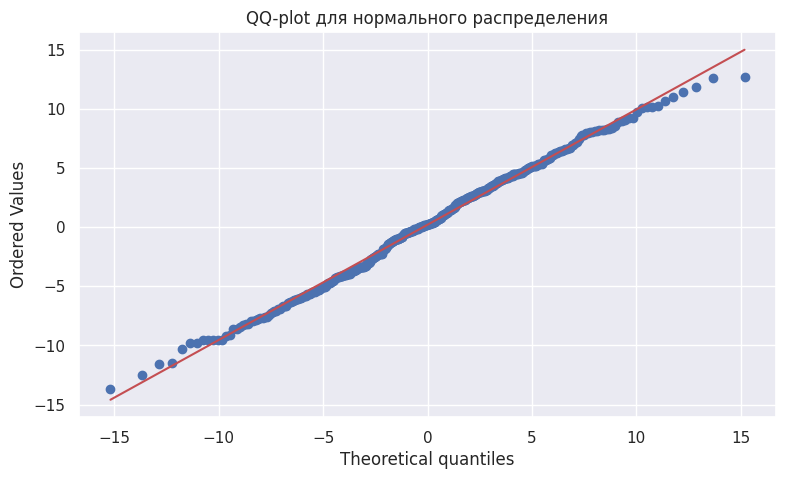

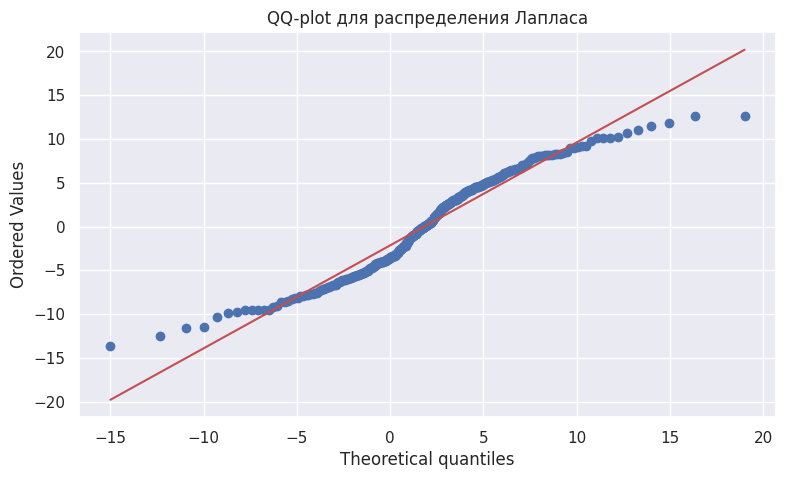

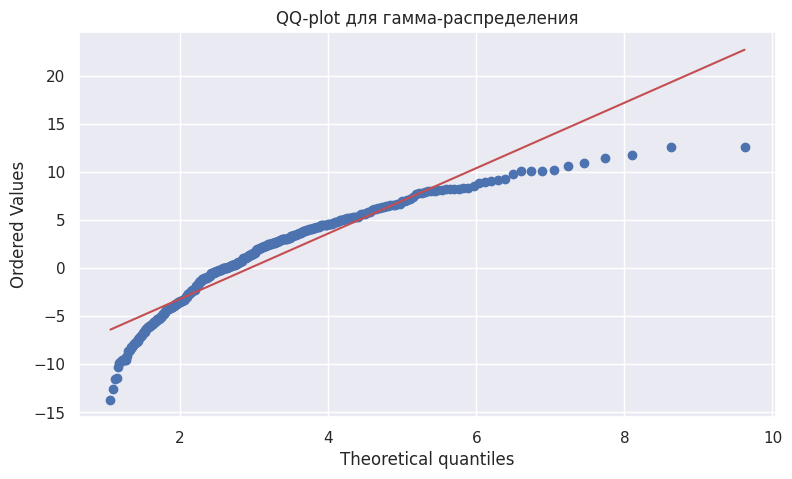

In [73]:
distr = [sps.norm(0, (THETA**2 / 3) ** 0.5), sps.laplace(2, 3), sps.gamma(2, 1)]

sns.set(style="darkgrid")
labels = ["QQ-plot для нормального распределения", "QQ-plot для распределения Лапласа","QQ-plot для гамма-распределения"]

for i in range(3):
    plt.figure(figsize=(9, 5))
    _ = sps.probplot(((theta_hat - THETA) * np.sqrt(n_range))[:, -1], dist=distr[i], plot=plt)
    plt.title(labels[i])

plt.show()

По QQ-plot + выводу очевидно, что истинна сходимость к распределению $N(0, \theta^2/3)$

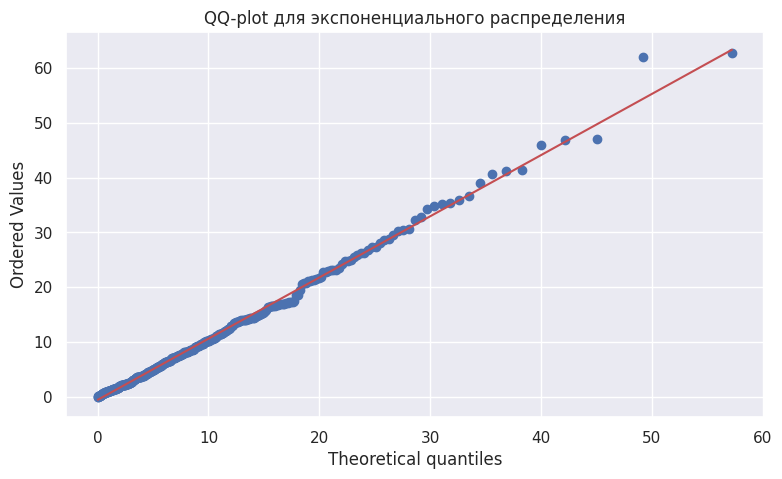

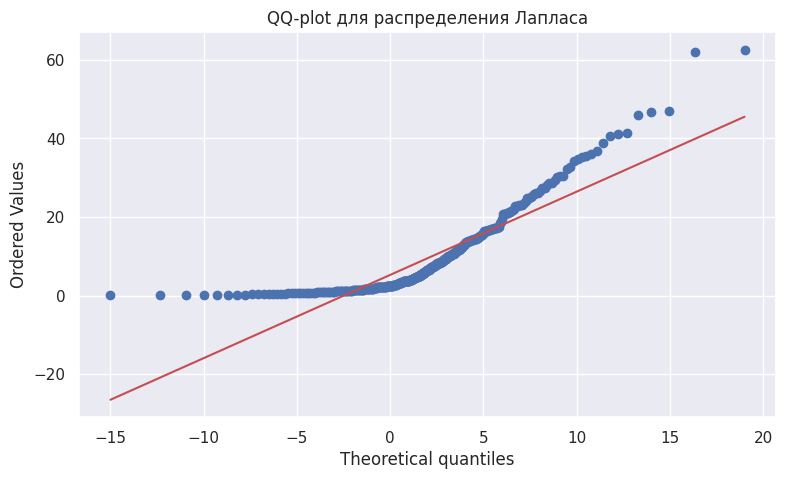

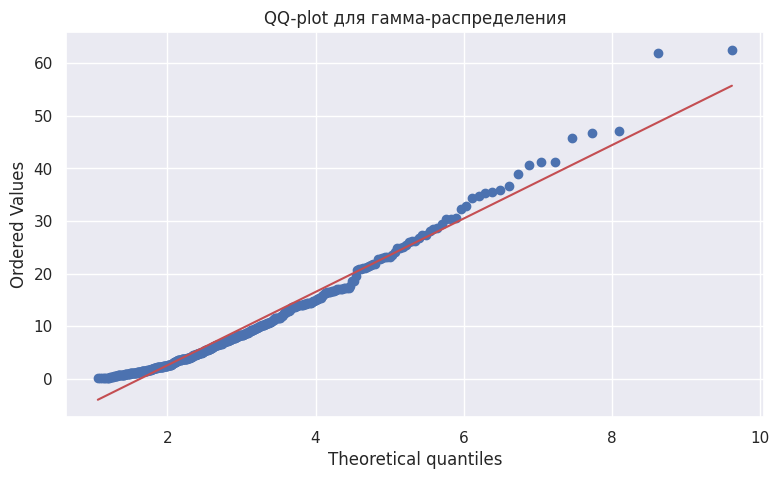

In [74]:
distr = [sps.expon(scale=THETA), sps.laplace(2, 3), sps.gamma(2, 1)]

sns.set(style="darkgrid")
labels = ["QQ-plot для экспоненциального распределения", "QQ-plot для распределения Лапласа",
          "QQ-plot для гамма-распределения"]

for i in range(3):
    plt.figure(figsize=(9, 5))
    _ = sps.probplot((THETA - (theta_star - THETA) * n_range)[:, -1], dist=distr[i], plot=plt)
    plt.title(labels[i])

plt.show()

<font color="#ae69c9ff">

Здесь уже не очевидно. Однако, благодаря выводу, мы знаем, что истинна сходимость к $Exp(1/\theta)$

5. Бонусная часть (+5 баллов): Если Вы нашли семейство распределений, которое по QQ-plot соответствует выборке, то докажите строго, что $n(\theta^* - \theta)$ сходится к нему. Заметьте, что это утверждение от асимптотической нормальности отличается только заменой $\sqrt{n}$ на $n$. Такие оценки называются **сверхнормальными**. В конце доказательства поясните:

- как множитель, зависящий от $n$, связан с скоростью сходимости оценки на практике?
- лучше ли сверхномальная оценка, чем нормальная оценка?

<font color="#ae69c9ff">

**Доказательство:**

$\theta - n(\theta^* - \theta) = \theta-((n+1)X_{n}-n\theta)=(n+1)(\theta-X_{n})$\
$P\left( (n+1)(\theta-X_{n}) \leqslant x \right) = P\left( \theta-X_{n} \leqslant \frac{x}{n+1} \right) = 1 - P\left( X_{n} \leqslant \frac{(n+1)\theta-x}{n+1} \right) = 1 - \left( \frac{(n+1)\theta-x}{\theta(n+1)} \right)^n = 1 - \left( 1 - \frac{x/\theta}{n+1} \right)^n = 1 - e^{-1/\theta}$, так как функция распределения однозначно соответствует распределению, то: $\theta - n(\theta^* - \theta) \sim Exp(1/\theta)$

**Ответы на вопросы:**
- высокий множитель хорош тем, что для проверки сходимости нужно будет намного меньше данных, чтобы заметить значимый результат. Например, для первой оценки из этого задания дисперсия зависит линейно от $1/n$, а для второй - квадратично (см 3 или 4 задачу, там упоминалось)
- с точки зрения асимптотики - да, но даже в нашем случае сверхнормальная оценка подвержена выбросам, т.к. учитывает только $X_{(n)}$. Кроме того, предположу, что при малом количестве данных огромной разницы между оценками мы не увидим

6. Сделайте вывод о том, какая оценка лучше на практике. Зачем может быть важно знать точную скорость сходимости (функцию от $n$) и предельное распределение?

<font color="#ae69c9ff">

Как я знаю, на практике "идеальное" распределение данных встречается редко, поэтому полагаться только на сверхсильную оценку может быть опрометчиво. Имеет смысл использовать комбинацию/обе вместе с обычной оценкой.

Знать распределение важно, так как опираясь на него можно взять очень малое количество данных и всё ещё получить неплохую погрешность (см предлагаемое количество элементов в выборке в заданиях 4 и 5). Кроме того, предельное распределение может помочь нам получить нужные оценки теоретически.

**Не забудьте перезапустить с нуля весь ноутбук перед отправкой! Habe Mut, dich deines eigenen Verstandes zu bedienen!**